# Exploring the design space of combinatorial CRISPR experiments

## 1. Load packages

In [3]:
using Random 
using Plots  
using Distributions 
using LinearAlgebra
using Combinatorics
using BioCCP


(process:18124): GLib-GIO-WARNING **: 16:18:13.453: Unexpectedly, UWP app `HaukeGtze.7-ZipFileManagerUnofficial_1.2107.2.0_x64__6bk20wvc8rfx2' (AUMId `HaukeGtze.7-ZipFileManagerUnofficial_6bk20wvc8rfx2!zFM.exe') supports 36 extensions but has no verbs


## 2. Simulation-based approach

### 2.1 gRNA relative frequency distributionin combinatorial gRNA/Cas library

In [4]:
function gRNA_frequency_distribution(m, sd, l, u, gRNA_total; normalize = true, visualize=false)
    d_gRNAlibrary = truncated(Normal(m, sd), l, u)
    gRNA_abundances = collect(rand(d_gRNAlibrary, gRNA_total))
     if visualize
        return histogram(gRNA_abundances, label="", 
            xlabel="Number of reads per gene", 
            ylabel="absolute frequency", title="Read distribution")
    else
        if normalize
            gRNA_abundances /= sum(gRNA_abundances)
        end
        return gRNA_abundances
    end
end

gRNA_frequency_distribution (generic function with 1 method)

### 2.2 gRNA-specific genome editing efficiency

In [1]:
function gRNA_activity_distribution(p_high_activity, μ_high_activity, μ_low_activity, σ_activity, n_gRNAs; visualize=false)   
    d_activity = Binomial(1, p_high_activity)
    d_highactivity = truncated(Normal(μ_high_activity, σ_activity), 0.01, 1)
    d_lowactivity = truncated(Normal(μ_low_activity, σ_activity), 0.01, 1)
    p_gRNA_act = zeros(n_gRNAs) # initialize
    for i in 1:n_gRNAs
        if rand(d_activity, 1) == [1]
            p_gRNA_act[i] = rand(d_highactivity, 1)[1]
        else
            p_gRNA_act[i] = rand(d_lowactivity, 1)[1]
        end
    end
    if visualize
        return histogram(p_gRNA_act, label="", xlabel="gRNA activity", ylabel="absolute frequency", title="gRNA activity distribution")

    else
        return p_gRNA_act
    end
end

gRNA_activity_distribution (generic function with 1 method)

### 2.3 Simulation function

In [6]:
function simulate_Nₓ₁(n_targets, 
                                         n_gRNA_pergene, 
                                         n_gRNA_perconstruct, 
                                         n_gRNA_total, 
                                         p_gRNA_library, 
                                         p_gRNA_act, ϵ_knockout_global; iter=500)
    """ 
    INPUT
  
    
    OUTPUT
    E: expected minimum number of plants to gRNA_read_distributionsee each pairwise combination at least once
    sd: standard deviation on the minimum number of plants
    """
    @assert n_targets * n_gRNA_pergene == n_gRNA_total
    
    T_vec = [] #stores number of plants required for each experiment
        for i in 1:iter       
            genes_vec = [] # Initialize matrix to count pairwise interactions
            T = 0
            while genes_vec != collect(1:n_targets) # check if all pairwise combinations are present
             
                T += 1 # count how many plants must be sampled to fill pairwise interaction matrix
                
                # sample combinatorial gRNA/Cas9 construct
                gRNA_indices_construct = findall((rand(Multinomial(n_gRNA_perconstruct, p_gRNA_library))) .!= 0)
                
                # execute mutations
                gRNA_indices_mutations = [gRNA for gRNA in gRNA_indices_construct if rand(Binomial(1, p_gRNA_act[gRNA])) == 1]
            
                # effective gene knockout (loss-of-function) ?
                gRNA_indices_KO = [gRNA for gRNA in gRNA_indices_mutations if rand(Binomial(1, ϵ_knockout_global)) == 1]
            
                # which genes are knocked out?
                genes_indices_KO = Int.(ceil.(gRNA_indices_KO / n_gRNA_pergene))
                 append!(genes_vec, genes_indices_KO)
                genes_vec = Int.(sort(unique(genes_vec)))
            end
            push!(T_vec, T)   
              
        end
        E = mean(T_vec); sd = std(T_vec)
    return E, sd
end
   

simulate_Nₓ₁ (generic function with 1 method)

In [64]:
using BioCCP

function BioCCP_Nₓ₁(n_targets, 
                                         n_gRNA_pergene, 
                                         n_gRNA_perconstruct, 
                                         n_gRNA_total, 
                                         p_gRNA_library, 
                                         p_gRNA_act, ϵ_knockout_global)
    
    p_gRNAs = p_gRNA_library .* p_gRNA_act * ϵ_knockout_global
    p_genes = [sum(p_gRNAs[i:i+n_gRNA_pergene-1]) for i in 1:n_gRNA_pergene:n_gRNA_total]
    return expectation_minsamplesize(n_targets; p=p_genes, r=n_gRNA_perconstruct, normalize=false), 
    std_minsamplesize(n_targets; p=p_genes, r=n_gRNA_perconstruct, normalize=false)
end

function simulate_Nₓ₂(n_targets, 
                                         n_gRNA_pergene, 
                                         n_gRNA_perconstruct, 
                                         n_gRNA_total, 
                                         p_gRNA_library, 
                                         p_gRNA_act, ϵ_knockout_global; iter=500)
    """ 
    INPUT
  
    
    OUTPUT
    E: expected minimum number of plants to gRNA_read_distributionsee each pairwise combination at least once
    sd: standard deviation on the minimum number of plants
    """
    @assert n_targets * n_gRNA_pergene == n_gRNA_total
#     @assert sum(p_gRNA_library) == 1
    
    T_vec = [] #stores number of plants required for each experiment
        for i in 1:iter     
            if i % 100 == 0
                println("Iteration: $i ... Calculating minimum number of plants ... \n")
            end   
            X_interactions_count = zeros(n_targets, n_targets) # Initialize matrix to count pairwise interactions
            T = 0
            while X_interactions_count != ones(n_targets, n_targets) # check if all pairwise combinations are present
                T += 1 # count how many plants must be sampled to fill pairwise interaction matrix
                
                # sample combinatorial gRNA/Cas9 construct
                gRNA_indices_construct = findall((rand(Multinomial(n_gRNA_perconstruct, p_gRNA_library))) .!= 0)
                
                # execute mutations
                gRNA_indices_mutations = [gRNA for gRNA in gRNA_indices_construct if rand(Binomial(1, p_gRNA_act[gRNA])) == 1]
            
                # effective gene knockout (loss-of-function) ?
                gRNA_indices_KO = [gRNA for gRNA in gRNA_indices_mutations if rand(Binomial(1, ϵ_knockout_global)) == 1]
            
                # which genes are knocked out?
                genes_indices_KO = Int.(ceil.(gRNA_indices_KO / n_gRNA_pergene))
            
                # which pairwise combinations are present?
                interactions = collect(combinations(genes_indices_KO, 2))
                
                # Store represented combinations in matrix
                for interaction in interactions
                    j = interaction[1]; k = interaction[2]
                    X_interactions_count[j,k] = 1; X_interactions_count[k,j] = 1; X_interactions_count[j,j] = 1; X_interactions_count[k,k] = 1          
                end  
            end
            push!(T_vec, T)   
              
        end
        E = mean(T_vec); sd = std(T_vec)
    return E, sd
end

using BioCCP

function BioCCP_Nₓ₂(n_targets, 
                                         n_gRNA_pergene, 
                                         n_gRNA_perconstruct, 
                                         n_gRNA_total, 
                                         p_gRNA_library, 
                                         p_gRNA_act, ϵ_knockout_global)
    
    # how many pairwise combinations of gRNAs
    ind_combinations_gRNA = collect(combinations(1:n_gRNA_total, 2))
    n_combinations_gRNA = length(ind_combinations_gRNA)
    
    # calculate probability and activity of gRNA combinations
    p_combinations_gRNA_library = zeros(n_combinations_gRNA)
    p_combinations_gRNA_act = zeros(n_combinations_gRNA)
    for i in 1:n_combinations_gRNA
        p_combinations_gRNA_library[i] = p_gRNA_library[ind_combinations_gRNA[i][1]] * p_gRNA_library[ind_combinations_gRNA[i][2]]
        p_combinations_gRNA_act[i] = p_gRNA_act[ind_combinations_gRNA[i][1]] * p_gRNA_act[ind_combinations_gRNA[i][2]]
    end
    
    # normalize probability gRNA combinations
    p_combinations_gRNA_library /= sum(p_combinations_gRNA_library)

    # select pairwise gRNA combinations of which each component codes for different gene (goal is to study combinations of knockouts in different genes)
    p_combinations_gRNA_library_interest = []
    p_combinations_gRNA_act_interest = []
    ind_combinations_gRNA_interest = []
    for i in 1:n_combinations_gRNA
        if ceil(ind_combinations_gRNA[i][1]/n_gRNA_pergene) != ceil(ind_combinations_gRNA[i][2]/n_gRNA_pergene)
            push!(p_combinations_gRNA_library_interest, p_combinations_gRNA_library[i])
            push!(p_combinations_gRNA_act_interest, p_combinations_gRNA_act[i])
            push!(ind_combinations_gRNA_interest, ind_combinations_gRNA[i])
        end
    end
        
    n_combinations_gRNA_interest = length(p_combinations_gRNA_library_interest)
    p_combinations_gRNA = p_combinations_gRNA_library_interest .* p_combinations_gRNA_act_interest * ϵ_knockout_global^2

    #### INTEGREREN PER GENCOMBINATIE
    p_genes_matrix = zeros(n_targets, n_targets)
    for i in 1:n_combinations_gRNA_interest
        gene1 = Int(ceil(ind_combinations_gRNA_interest[i][1]/n_gRNA_pergene))
        gene2 = Int(ceil(ind_combinations_gRNA_interest[i][2]/n_gRNA_pergene))
        p_genes_matrix[gene1, gene2] += p_combinations_gRNA[i]
    end
    p_genes = collect([p_genes_matrix[i, j] for j in 2:size(p_genes_matrix, 1) for i in 1:j-1])  
    n_combinations_genes = length(p_genes)
    combinations_pp = length(collect(combinations(1:n_gRNA_perconstruct, 2)))
    
    return expectation_minsamplesize(n_combinations_genes; p=p_genes, r=combinations_pp, normalize=false), std_minsamplesize(n_combinations_genes; p=p_genes, r=combinations_pp, normalize=false)
end
   

BioCCP_Nₓ₂ (generic function with 1 method)

In [8]:
function simulate_Nₓ₂_countKOs(n_targets, 
                                         n_gRNA_pergene, 
                                         n_gRNA_perconstruct, 
                                         n_gRNA_total, 
                                         p_gRNA_library, 
                                         p_gRNA_act, ϵ_knockout_global; iter=500)
     
    @assert n_targets * n_gRNA_pergene == n_gRNA_total
    
            n_KOs = []
       
            for j in 1:100000
                               
                # sample combinatorial gRNA/Cas9 construct
                gRNA_indices_construct = findall((rand(Multinomial(n_gRNA_perconstruct, p_gRNA_library))) .!= 0)
                
                # execute mutations
                gRNA_indices_mutations = [gRNA for gRNA in gRNA_indices_construct if rand(Binomial(1, p_gRNA_act[gRNA])) == 1]
            
                # effective gene knockout (loss-of-function) ?
                gRNA_indices_KO = [gRNA for gRNA in gRNA_indices_mutations if rand(Binomial(1, ϵ_knockout_global)) == 1]
            
                # which genes are knocked out?
                genes_indices_KO = Int.(ceil.(gRNA_indices_KO / n_gRNA_pergene))
            
               push!(n_KOs, length(unique((genes_indices_KO))))
            end  
 
    return n_KOs
end

simulate_Nₓ₂_countKOs (generic function with 1 method)

In [66]:
function simulate_Nₓ₃(n_targets, 
                                         n_gRNA_pergene, 
                                         n_gRNA_perconstruct, 
                                         n_gRNA_total, 
                                         p_gRNA_library, 
                                         p_gRNA_act, ϵ_knockout_global; iter=500)
    """ 
    INPUT
  
    
    OUTPUT
    E: expected minimum number of plants to gRNA_read_distributionsee each pairwise combination at least once
    sd: standard deviation on the minimum number of plants
    """
    @assert n_targets * n_gRNA_pergene == n_gRNA_total
#     @assert sum(p_gRNA_library) == 1
    
    T_vec = [] #stores number of plants required for each experiment
        for i in 1:iter     
            if i % 100 == 0
                println("Iteration: $i ... Calculating minimum number of plants ... \n")
            end   
            X_interactions_count = zeros(n_targets, n_targets, n_targets) # Initialize matrix to count triple interactions
            T = 0
            while X_interactions_count != ones(n_targets, n_targets, n_targets) # check if all triple combinations are present
                T += 1 # count how many plants must be sampled to fill triple interaction matrix
                
                # sample combinatorial gRNA/Cas9 construct
                gRNA_indices_construct = findall((rand(Multinomial(n_gRNA_perconstruct, p_gRNA_library))) .!= 0)
                
                # execute mutations
                gRNA_indices_mutations = [gRNA for gRNA in gRNA_indices_construct if rand(Binomial(1, p_gRNA_act[gRNA])) == 1]
            
                # effective gene knockout (loss-of-function) ?
                gRNA_indices_KO = [gRNA for gRNA in gRNA_indices_mutations if rand(Binomial(1, ϵ_knockout_global)) == 1]
            
                # which genes are knocked out?
                genes_indices_KO = Int.(ceil.(gRNA_indices_KO / n_gRNA_pergene))
            
                # which triple combinations are present?
                interactions = collect(combinations(genes_indices_KO, 3))
                
                # Store represented combinations in matrix
                for interaction in interactions
                    j = interaction[1]
                    k = interaction[2]
                    l = interaction[3]
                    X_interactions_count[j,k,l] = 1
                    X_interactions_count[k,j,l] = 1
                    X_interactions_count[l,j,k] = 1
                    X_interactions_count[l,k,j] = 1
                    X_interactions_count[j,l,k] = 1
                    X_interactions_count[k,l,j] = 1
        
                    X_interactions_count[:,l,l] .= 1
                    X_interactions_count[:,k,k] .= 1
                    X_interactions_count[:,j,j] .= 1
                    X_interactions_count[l,:,l] .= 1
                    X_interactions_count[k,:,k] .= 1
                    X_interactions_count[j,:,j] .= 1
        
                    X_interactions_count[j,j,:] .= 1
                    X_interactions_count[k,k,:] .= 1
                    X_interactions_count[l,l,:] .= 1
                end  
            end
            push!(T_vec, T)   
              
        end
        E = mean(T_vec); sd = std(T_vec)
    return E, sd
end
   
        
function BioCCP_Nₓ₃(n_targets, 
                                         n_gRNA_pergene, 
                                         n_gRNA_perconstruct, 
                                         n_gRNA_total, 
                                         p_gRNA_library, 
                                         p_gRNA_act, ϵ_knockout_global)
    
    # how many pairwise combinations of gRNAs
    ind_combinations_gRNA = collect(combinations(1:n_gRNA_total, 3))
    n_combinations_gRNA = length(ind_combinations_gRNA)
    
    # calculate probability and activity of triple gRNA combinations
    p_combinations_gRNA_library = zeros(n_combinations_gRNA)
    p_combinations_gRNA_act = zeros(n_combinations_gRNA)
    for i in 1:n_combinations_gRNA
        p_combinations_gRNA_library[i] = p_gRNA_library[ind_combinations_gRNA[i][1]] * p_gRNA_library[ind_combinations_gRNA[i][2]] * p_gRNA_library[ind_combinations_gRNA[i][3]]
        p_combinations_gRNA_act[i] = p_gRNA_act[ind_combinations_gRNA[i][1]] * p_gRNA_act[ind_combinations_gRNA[i][2]] * p_gRNA_act[ind_combinations_gRNA[i][3]]
    end
    
    # normalize probability gRNA combinations
    p_combinations_gRNA_library /= sum(p_combinations_gRNA_library)

    # select triple gRNA combinations of which each component codes for different gene (goal is to study combinations of knockouts in different genes)
    p_combinations_gRNA_library_interest = []
    p_combinations_gRNA_act_interest = []
    ind_combinations_gRNA_interest = []
    for i in 1:n_combinations_gRNA
        if ceil(ind_combinations_gRNA[i][1]/n_gRNA_pergene) != ceil(ind_combinations_gRNA[i][2]/n_gRNA_pergene) && ceil(ind_combinations_gRNA[i][1]/n_gRNA_pergene) != ceil(ind_combinations_gRNA[i][3]/n_gRNA_pergene) && ceil(ind_combinations_gRNA[i][3]/n_gRNA_pergene) != ceil(ind_combinations_gRNA[i][2]/n_gRNA_pergene)
            push!(p_combinations_gRNA_library_interest, p_combinations_gRNA_library[i])
            push!(p_combinations_gRNA_act_interest, p_combinations_gRNA_act[i])
            push!(ind_combinations_gRNA_interest, ind_combinations_gRNA[i])
        end
    end
        
    n_combinations_gRNA_interest = length(p_combinations_gRNA_library_interest)
    p_combinations_gRNA = p_combinations_gRNA_library_interest .* p_combinations_gRNA_act_interest * ϵ_knockout_global^3

    #### INTEGREREN PER GENCOMBINATIE
    p_genes_matrix = zeros(n_targets, n_targets, n_targets)
    for i in 1:n_combinations_gRNA_interest
        gene1 = Int(ceil(ind_combinations_gRNA_interest[i][1]/n_gRNA_pergene))
        gene2 = Int(ceil(ind_combinations_gRNA_interest[i][2]/n_gRNA_pergene))
        gene3 = Int(ceil(ind_combinations_gRNA_interest[i][3]/n_gRNA_pergene))
        p_genes_matrix[gene1, gene2, gene3] += p_combinations_gRNA[i]
    end
    
    combinations_genes = collect(combinations(1:n_targets, 3))
    p_genes = []
        for combination in combinations_genes
            push!(p_genes, p_genes_matrix[combination[1], combination[2], combination[3]])
        end
        
    n_combinations_genes = length(p_genes)
    combinations_pp = length(collect(combinations(1:n_gRNA_perconstruct, 3)))
    
    return expectation_minsamplesize(n_combinations_genes; p=p_genes, r=combinations_pp, normalize=false), std_minsamplesize(n_combinations_genes; p=p_genes, r=combinations_pp, normalize=false)
end

BioCCP_Nₓ₃ (generic function with 1 method)

In [6]:
# count KOs
targets = 20
gRNA_pergene = 6
gRNA_total = targets * gRNA_pergene
gRNA_perconstruct = 2
μ_high_activity = 0.9
μ_low_activity = 0.1
σ_activity = 0.01

ρ  = 2
l = 50
u = 50*ρ 
m= (l+u)/2
sd = (u-l)/2
Random.seed!(1)
p_gRNA_library = gRNA_frequency_distribution(m, sd, l, u, gRNA_total; normalize = true, visualize=false);

p_high_activity = 0.9
d_act = gRNA_activity_distribution(p_high_activity, μ_high_activity, μ_low_activity, σ_activity, gRNA_total; visualize=false); 

ϵ = 0.9
n_KOs_90 = simulate_Nₓ₂_countKOs(targets, 
                                         gRNA_pergene, 
                                         gRNA_perconstruct, 
                                         gRNA_total, 
                                         p_gRNA_library, 
                                         d_act, ϵ; iter=500)
ϵ = 0.8
n_KOs_80 = simulate_Nₓ₂_countKOs(targets, 
                                         gRNA_pergene, 
                                         gRNA_perconstruct, 
                                         gRNA_total, 
                                         p_gRNA_library, 
                                         d_act, ϵ; iter=500)
ϵ = 0.7
n_KOs_70 = simulate_Nₓ₂_countKOs(targets, 
                                         gRNA_pergene, 
                                         gRNA_perconstruct, 
                                         gRNA_total, 
                                         p_gRNA_library, 
                                         d_act, ϵ; iter=500)

# count KOs

gRNA_perconstruct = 6

ϵ = 0.9
n_KOs_overshoot6_90 = simulate_Nₓ₂_countKOs(targets, 
                                         gRNA_pergene, 
                                         gRNA_perconstruct, 
                                         gRNA_total, 
                                         p_gRNA_library, 
                                         d_act, ϵ; iter=500)


ϵ = 0.8
n_KOs_overshoot6_80 = simulate_Nₓ₂_countKOs(targets, 
                                         gRNA_pergene, 
                                         gRNA_perconstruct, 
                                         gRNA_total, 
                                         p_gRNA_library, 
                                         d_act, ϵ; iter=500)


ϵ = 0.7
n_KOs_overshoot6_70 = simulate_Nₓ₂_countKOs(targets, 
                                         gRNA_pergene, 
                                         gRNA_perconstruct, 
                                         gRNA_total, 
                                         p_gRNA_library, 
                                         d_act, ϵ; iter=500)

100000-element Array{Any,1}:
 4
 3
 4
 3
 4
 3
 1
 4
 3
 2
 2
 5
 3
 ⋮
 0
 3
 4
 2
 2
 2
 3
 2
 5
 3
 3
 2

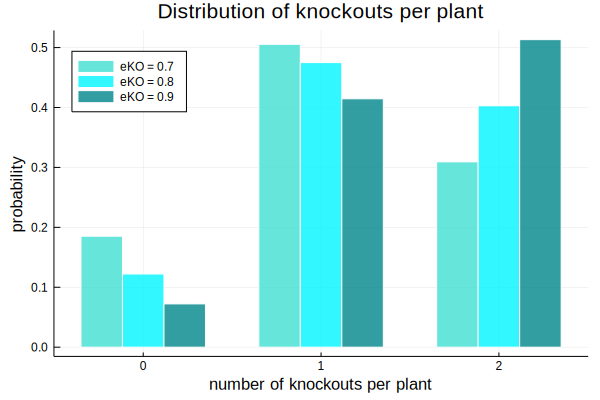

In [7]:
using StatsPlots

measles = normalize([sum(n_KOs_70 .== 0), sum(n_KOs_70 .== 1), sum(n_KOs_70 .== 2)], 1)
mumps = normalize([sum(n_KOs_80 .== 0), sum(n_KOs_80 .== 1), sum(n_KOs_80 .== 2)], 1)
chickenPox = normalize([sum(n_KOs_90 .== 0), sum(n_KOs_90 .== 1), sum(n_KOs_90 .== 2)], 1)

ticklabel = string.(collect('0':'6'))
groupedbar([measles mumps chickenPox], bar_position = :dodge, bar_width=0.7, xticks=(1:36, ticklabel),
fill=[:turquoise :turquoise1 :turquoise4], linecolor=:white, fillalpha=0.8, label=["eKO = 0.7" "eKO = 0.8" "eKO = 0.9"],
size = (600, 400), legend=:topleft,
xlabel="number of knockouts per plant", ylabel="probability", title="Distribution of knockouts per plant")


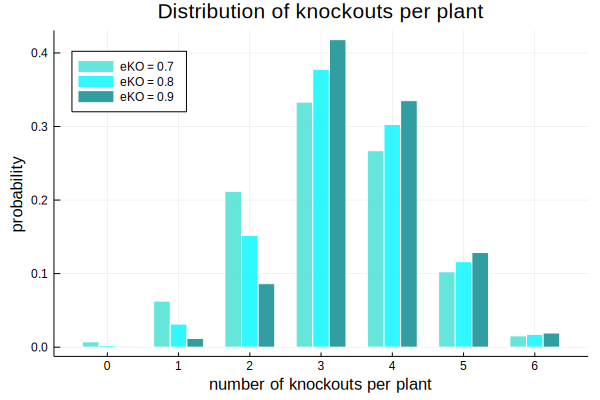

In [8]:
measles = normalize([sum(n_KOs_overshoot6_70 .== 0), sum(n_KOs_overshoot6_70 .== 1), sum(n_KOs_overshoot6_70 .== 2), sum(n_KOs_overshoot6_70 .== 3), sum(n_KOs_overshoot6_70 .== 4), sum(n_KOs_overshoot6_70 .== 5), sum(n_KOs_overshoot6_70 .== 6)], 1)
mumps = normalize([sum(n_KOs_overshoot6_80 .== 0), sum(n_KOs_overshoot6_80 .== 1), sum(n_KOs_overshoot6_80 .== 2), sum(n_KOs_overshoot6_70 .== 3), sum(n_KOs_overshoot6_70 .== 4), sum(n_KOs_overshoot6_70 .== 5), sum(n_KOs_overshoot6_70 .== 6)], 1)
chickenPox = normalize([sum(n_KOs_overshoot6_90 .== 0), sum(n_KOs_overshoot6_90 .== 1), sum(n_KOs_overshoot6_90 .== 2), sum(n_KOs_overshoot6_70 .== 3), sum(n_KOs_overshoot6_70 .== 4), sum(n_KOs_overshoot6_70 .== 5), sum(n_KOs_overshoot6_70 .== 6)], 1)

m = zeros(7, 3)
m[:,1],m[:,2], m[:,3]  = measles, mumps, chickenPox

ticklabel = string.(collect('0':'6'))
groupedbar(1:7, m, bar_position = :dodge, 
    linecolor=:white,
   fill=[:turquoise :turquoise1 :turquoise4],
    bar_width=0.7, xticks=(1:18, ticklabel), fillalpha=0.8,
xlabel="number of knockouts per plant", ylabel="probability", title="Distribution of knockouts per plant", 
label=["eKO = 0.7" "eKO = 0.8" "eKO = 0.9"], legend=:topleft,size = (600, 400))

In [ ]:
# Distributions

In [9]:
targets = 20
gRNA_pergene = 6
gRNA_total = targets * gRNA_pergene
gRNA_perconstruct = 2
Random.seed!(1)
p_high_activity = 0.9
μ_high_activity = 0.9
μ_low_activity = 0.1
σ_activity = 0.01
d_act = gRNA_activity_distribution(p_high_activity, μ_high_activity, μ_low_activity, σ_activity, gRNA_total; visualize=false); 
ϵ = 0.8

ρ  = 2
l = 50
u = 50*ρ 
m= (l+u)/2
sd = (u-l)/2
Random.seed!(1)
d_2 = gRNA_frequency_distribution(m, sd, l, u, gRNA_total; normalize = false, visualize=false)

120-element Vector{Float64}:
 73.23542152615255
 88.2869188445799
 54.828691849832154
 81.68911046572212
 54.34948020201756
 66.7716538535899
 62.94370211477211
 87.0172853636245
 74.9360454861423
 88.30111086547241
 81.09621683809631
 75.5061483473298
 66.16352349534873
  ⋮
 92.41170028624066
 78.15226380081546
 92.49618586254597
 52.944310726326904
 90.85970260704326
 66.94386144006428
 83.36486134919201
 99.31460017247444
 53.649850409381216
 76.30272343702003
 52.1272477044665
 84.34091880497137

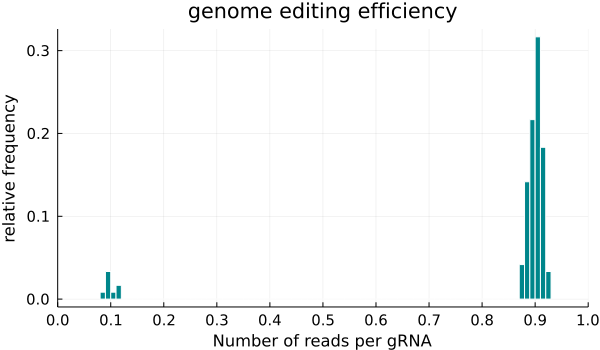

In [10]:
histogram(d_act, label="", xlabel="Number of reads per gRNA", 
     linecolor = "white", normalize = :probability, 
xtickfontsize=10,ytickfontsize=10, xlim = (0, 1), xticks=(0:0.1:1),
    color=:turquoise4, size=(600,350),
    bins = 150,
            ylabel="relative frequency", title="genome editing efficiency")

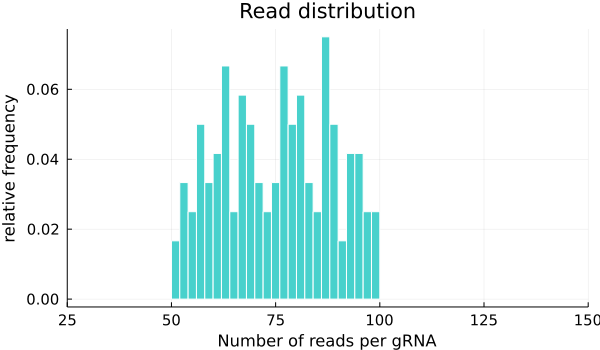

In [11]:
ρ  = 2
l = 50
u = 50*ρ 
m= (l+u)/2
sd = (u-l)/2
Random.seed!(1)
d_2 = gRNA_frequency_distribution(m, sd, l, u, gRNA_total; normalize = false, visualize=false)

histogram(d_2, label="", xlabel="Number of reads per gRNA", 
     linecolor = "white", normalize = :probability, 
xtickfontsize=10,ytickfontsize=10, xlim = (25, 150), 
    color=:mediumturquoise, size=(600,350),
    bins = 25,
            ylabel="relative frequency", title="Read distribution")

In [13]:
iter = 15

Es_p1_bioccp = zeros(iter, 6)
sds_p1_bioccp = zeros(iter, 6) 
for i in 1:iter
    for gRNA_pergene in 1:6
    gRNA_total = targets*gRNA_pergene
    d_1 = ones(gRNA_total)/gRNA_total
    d_act = ones(gRNA_total)
    E, sd = simulate_Nₓ₂(targets, 
                              gRNA_pergene, 
                              gRNA_perconstruct, 
                              gRNA_total, 
                              d_1, 
                              d_act, ϵ)
    Es_p1_bioccp[i,gRNA_pergene] = E
    sds_p1_bioccp[i,gRNA_pergene] = sd

    end
end

##2
ρ  = 2
l = 50
u = 50*ρ 
m= (l+u)/2
sd = (u-l)/2


### vary number of gRNAs per gene
Es_p2_bioccp = zeros(iter, 6)
sds_p2_bioccp = zeros(iter, 6) 
for i in 1:iter
    for gRNA_pergene in 1:6
    gRNA_total = targets*gRNA_pergene
    d_2 = gRNA_frequency_distribution(m, sd, l, u, gRNA_total; normalize = true, visualize=false)
    d_act = ones(gRNA_total)
    E, sd = simulate_Nₓ₂(targets, 
                              gRNA_pergene, 
                              gRNA_perconstruct, 
                              gRNA_total, 
                              d_2, 
                              d_act, ϵ)
    Es_p2_bioccp[i,gRNA_pergene] = E
    sds_p2_bioccp[i,gRNA_pergene] = sd
    end
end

##4
ρ = 4
l = 50
u = 50 * ρ 
m= (l+u)/2
sd = (u-l)/2


### vary number of gRNAs per gene
Es_p4_bioccp = zeros(iter, 6)
sds_p4_bioccp = zeros(iter, 6) 
for i in 1:iter
    for gRNA_pergene in 1:6
    gRNA_total = targets*gRNA_pergene
    d_4 = gRNA_frequency_distribution(m, sd, l, u, gRNA_total; normalize = true, visualize=false)
    d_act = ones(gRNA_total)
    E, sd = simulate_Nₓ₂(targets, 
                              gRNA_pergene, 
                              gRNA_perconstruct, 
                              gRNA_total, 
                              d_4, 
                              d_act, ϵ)
    Es_p4_bioccp[i,gRNA_pergene] = E
    sds_p4_bioccp[i,gRNA_pergene] = sd
    end
end

##8
ρ  = 8
l = 50
u = 50 * ρ 
m= (l+u)/2
sd = (u-l)/2


### vary number of gRNAs per gene
Es_p8_bioccp = zeros(iter, 6)
sds_p8_bioccp = zeros(iter, 6) 
for i in 1:iter
    for gRNA_pergene in 1:6
    gRNA_total = targets*gRNA_pergene
        ρ  = 8
l = 50
u = 50 * ρ 
m= (l+u)/2
sd = (u-l)/2

    d_8 = gRNA_frequency_distribution(m, sd, l, u, gRNA_total; normalize = true, visualize=false)
    d_act = ones(gRNA_total)
    E, sd = simulate_Nₓ₂(targets, 
                              gRNA_pergene, 
                              gRNA_perconstruct, 
                              gRNA_total, 
                              d_8, 
                              d_act, ϵ)
    Es_p8_bioccp[i,gRNA_pergene] = E
    sds_p8_bioccp[i,gRNA_pergene] = sd
    end
end

Iteration: 100 ... Calculating minimum number of plants ... 

Iteration: 200 ... Calculating minimum number of plants ... 

Iteration: 300 ... Calculating minimum number of plants ... 

Iteration: 400 ... Calculating minimum number of plants ... 

Iteration: 500 ... Calculating minimum number of plants ... 

Iteration: 100 ... Calculating minimum number of plants ... 

Iteration: 200 ... Calculating minimum number of plants ... 

Iteration: 300 ... Calculating minimum number of plants ... 

Iteration: 400 ... Calculating minimum number of plants ... 

Iteration: 500 ... Calculating minimum number of plants ... 

Iteration: 100 ... Calculating minimum number of plants ... 

Iteration: 200 ... Calculating minimum number of plants ... 

Iteration: 300 ... Calculating minimum number of plants ... 

Iteration: 400 ... Calculating minimum number of plants ... 

Iteration: 500 ... Calculating minimum number of plants ... 

Iteration: 100 ... Calculating minimum number of plants ... 

Iteratio

Iteration: 200 ... Calculating minimum number of plants ... 

Iteration: 300 ... Calculating minimum number of plants ... 

Iteration: 400 ... Calculating minimum number of plants ... 

Iteration: 500 ... Calculating minimum number of plants ... 

Iteration: 100 ... Calculating minimum number of plants ... 

Iteration: 200 ... Calculating minimum number of plants ... 

Iteration: 300 ... Calculating minimum number of plants ... 

Iteration: 400 ... Calculating minimum number of plants ... 

Iteration: 500 ... Calculating minimum number of plants ... 

Iteration: 100 ... Calculating minimum number of plants ... 

Iteration: 200 ... Calculating minimum number of plants ... 

Iteration: 300 ... Calculating minimum number of plants ... 

Iteration: 400 ... Calculating minimum number of plants ... 

Iteration: 500 ... Calculating minimum number of plants ... 

Iteration: 100 ... Calculating minimum number of plants ... 

Iteration: 200 ... Calculating minimum number of plants ... 

Iteratio

Iteration: 300 ... Calculating minimum number of plants ... 

Iteration: 400 ... Calculating minimum number of plants ... 

Iteration: 500 ... Calculating minimum number of plants ... 

Iteration: 100 ... Calculating minimum number of plants ... 

Iteration: 200 ... Calculating minimum number of plants ... 

Iteration: 300 ... Calculating minimum number of plants ... 

Iteration: 400 ... Calculating minimum number of plants ... 

Iteration: 500 ... Calculating minimum number of plants ... 

Iteration: 100 ... Calculating minimum number of plants ... 

Iteration: 200 ... Calculating minimum number of plants ... 

Iteration: 300 ... Calculating minimum number of plants ... 

Iteration: 400 ... Calculating minimum number of plants ... 

Iteration: 500 ... Calculating minimum number of plants ... 

Iteration: 100 ... Calculating minimum number of plants ... 

Iteration: 200 ... Calculating minimum number of plants ... 

Iteration: 300 ... Calculating minimum number of plants ... 

Iteratio

Iteration: 400 ... Calculating minimum number of plants ... 

Iteration: 500 ... Calculating minimum number of plants ... 

Iteration: 100 ... Calculating minimum number of plants ... 

Iteration: 200 ... Calculating minimum number of plants ... 

Iteration: 300 ... Calculating minimum number of plants ... 

Iteration: 400 ... Calculating minimum number of plants ... 

Iteration: 500 ... Calculating minimum number of plants ... 

Iteration: 100 ... Calculating minimum number of plants ... 

Iteration: 200 ... Calculating minimum number of plants ... 

Iteration: 300 ... Calculating minimum number of plants ... 

Iteration: 400 ... Calculating minimum number of plants ... 

Iteration: 500 ... Calculating minimum number of plants ... 

Iteration: 100 ... Calculating minimum number of plants ... 

Iteration: 200 ... Calculating minimum number of plants ... 

Iteration: 300 ... Calculating minimum number of plants ... 

Iteration: 400 ... Calculating minimum number of plants ... 

Iteratio

Iteration: 500 ... Calculating minimum number of plants ... 

Iteration: 100 ... Calculating minimum number of plants ... 

Iteration: 200 ... Calculating minimum number of plants ... 

Iteration: 300 ... Calculating minimum number of plants ... 

Iteration: 400 ... Calculating minimum number of plants ... 

Iteration: 500 ... Calculating minimum number of plants ... 

Iteration: 100 ... Calculating minimum number of plants ... 

Iteration: 200 ... Calculating minimum number of plants ... 

Iteration: 300 ... Calculating minimum number of plants ... 

Iteration: 400 ... Calculating minimum number of plants ... 

Iteration: 500 ... Calculating minimum number of plants ... 

Iteration: 100 ... Calculating minimum number of plants ... 

Iteration: 200 ... Calculating minimum number of plants ... 

Iteration: 300 ... Calculating minimum number of plants ... 

Iteration: 400 ... Calculating minimum number of plants ... 

Iteration: 500 ... Calculating minimum number of plants ... 

Iteratio

Iteration: 100 ... Calculating minimum number of plants ... 

Iteration: 200 ... Calculating minimum number of plants ... 

Iteration: 300 ... Calculating minimum number of plants ... 

Iteration: 400 ... Calculating minimum number of plants ... 

Iteration: 500 ... Calculating minimum number of plants ... 

Iteration: 100 ... Calculating minimum number of plants ... 

Iteration: 200 ... Calculating minimum number of plants ... 

Iteration: 300 ... Calculating minimum number of plants ... 

Iteration: 400 ... Calculating minimum number of plants ... 

Iteration: 500 ... Calculating minimum number of plants ... 

Iteration: 100 ... Calculating minimum number of plants ... 

Iteration: 200 ... Calculating minimum number of plants ... 

Iteration: 300 ... Calculating minimum number of plants ... 

Iteration: 400 ... Calculating minimum number of plants ... 

Iteration: 500 ... Calculating minimum number of plants ... 

Iteration: 100 ... Calculating minimum number of plants ... 

Iteratio


Iteration: 200 ... Calculating minimum number of plants ... 

Iteration: 300 ... Calculating minimum number of plants ... 

Iteration: 400 ... Calculating minimum number of plants ... 

Iteration: 500 ... Calculating minimum number of plants ... 

Iteration: 100 ... Calculating minimum number of plants ... 

Iteration: 200 ... Calculating minimum number of plants ... 

Iteration: 300 ... Calculating minimum number of plants ... 

Iteration: 400 ... Calculating minimum number of plants ... 

Iteration: 500 ... Calculating minimum number of plants ... 

Iteration: 100 ... Calculating minimum number of plants ... 

Iteration: 200 ... Calculating minimum number of plants ... 

Iteration: 300 ... Calculating minimum number of plants ... 

Iteration: 400 ... Calculating minimum number of plants ... 

Iteration: 500 ... Calculating minimum number of plants ... 

Iteration: 100 ... Calculating minimum number of plants ... 

Iteration: 200 ... Calculating minimum number of plants ... 

Iterati


Iteration: 300 ... Calculating minimum number of plants ... 

Iteration: 400 ... Calculating minimum number of plants ... 

Iteration: 500 ... Calculating minimum number of plants ... 

Iteration: 100 ... Calculating minimum number of plants ... 

Iteration: 200 ... Calculating minimum number of plants ... 

Iteration: 300 ... Calculating minimum number of plants ... 

Iteration: 400 ... Calculating minimum number of plants ... 

Iteration: 500 ... Calculating minimum number of plants ... 

Iteration: 100 ... Calculating minimum number of plants ... 

Iteration: 200 ... Calculating minimum number of plants ... 

Iteration: 300 ... Calculating minimum number of plants ... 

Iteration: 400 ... Calculating minimum number of plants ... 

Iteration: 500 ... Calculating minimum number of plants ... 

Iteration: 100 ... Calculating minimum number of plants ... 

Iteration: 200 ... Calculating minimum number of plants ... 

Iteration: 300 ... Calculating minimum number of plants ... 

Iterati

Iteration: 400 ... Calculating minimum number of plants ... 

Iteration: 500 ... Calculating minimum number of plants ... 

Iteration: 100 ... Calculating minimum number of plants ... 

Iteration: 200 ... Calculating minimum number of plants ... 

Iteration: 300 ... Calculating minimum number of plants ... 

Iteration: 400 ... Calculating minimum number of plants ... 

Iteration: 500 ... Calculating minimum number of plants ... 

Iteration: 100 ... Calculating minimum number of plants ... 

Iteration: 200 ... Calculating minimum number of plants ... 

Iteration: 300 ... Calculating minimum number of plants ... 

Iteration: 400 ... Calculating minimum number of plants ... 

Iteration: 500 ... Calculating minimum number of plants ... 

Iteration: 100 ... Calculating minimum number of plants ... 

Iteration: 200 ... Calculating minimum number of plants ... 

Iteration: 300 ... Calculating minimum number of plants ... 

Iteration: 400 ... Calculating minimum number of plants ... 

Iteratio

Iteration: 500 ... Calculating minimum number of plants ... 

Iteration: 100 ... Calculating minimum number of plants ... 

Iteration: 200 ... Calculating minimum number of plants ... 

Iteration: 300 ... Calculating minimum number of plants ... 

Iteration: 400 ... Calculating minimum number of plants ... 

Iteration: 500 ... Calculating minimum number of plants ... 

Iteration: 100 ... Calculating minimum number of plants ... 

Iteration: 200 ... Calculating minimum number of plants ... 

Iteration: 300 ... Calculating minimum number of plants ... 

Iteration: 400 ... Calculating minimum number of plants ... 

Iteration: 500 ... Calculating minimum number of plants ... 

Iteration: 100 ... Calculating minimum number of plants ... 

Iteration: 200 ... Calculating minimum number of plants ... 

Iteration: 300 ... Calculating minimum number of plants ... 

Iteration: 400 ... Calculating minimum number of plants ... 

Iteration: 500 ... Calculating minimum number of plants ... 

Iteratio

Iteration: 100 ... Calculating minimum number of plants ... 

Iteration: 200 ... Calculating minimum number of plants ... 

Iteration: 300 ... Calculating minimum number of plants ... 

Iteration: 400 ... Calculating minimum number of plants ... 

Iteration: 500 ... Calculating minimum number of plants ... 

Iteration: 100 ... Calculating minimum number of plants ... 

Iteration: 200 ... Calculating minimum number of plants ... 

Iteration: 300 ... Calculating minimum number of plants ... 

Iteration: 400 ... Calculating minimum number of plants ... 

Iteration: 500 ... Calculating minimum number of plants ... 

Iteration: 100 ... Calculating minimum number of plants ... 

Iteration: 200 ... Calculating minimum number of plants ... 

Iteration: 300 ... Calculating minimum number of plants ... 

Iteration: 400 ... Calculating minimum number of plants ... 

Iteration: 500 ... Calculating minimum number of plants ... 

Iteration: 100 ... Calculating minimum number of plants ... 

Iteratio

Iteration: 200 ... Calculating minimum number of plants ... 

Iteration: 300 ... Calculating minimum number of plants ... 

Iteration: 400 ... Calculating minimum number of plants ... 

Iteration: 500 ... Calculating minimum number of plants ... 

Iteration: 100 ... Calculating minimum number of plants ... 

Iteration: 200 ... Calculating minimum number of plants ... 

Iteration: 300 ... Calculating minimum number of plants ... 

Iteration: 400 ... Calculating minimum number of plants ... 

Iteration: 500 ... Calculating minimum number of plants ... 

Iteration: 100 ... Calculating minimum number of plants ... 

Iteration: 200 ... Calculating minimum number of plants ... 

Iteration: 300 ... Calculating minimum number of plants ... 

Iteration: 400 ... Calculating minimum number of plants ... 

Iteration: 500 ... Calculating minimum number of plants ... 

Iteration: 100 ... Calculating minimum number of plants ... 

Iteration: 200 ... Calculating minimum number of plants ... 

Iteratio


Iteration: 300 ... Calculating minimum number of plants ... 

Iteration: 400 ... Calculating minimum number of plants ... 

Iteration: 500 ... Calculating minimum number of plants ... 

Iteration: 100 ... Calculating minimum number of plants ... 

Iteration: 200 ... Calculating minimum number of plants ... 

Iteration: 300 ... Calculating minimum number of plants ... 

Iteration: 400 ... Calculating minimum number of plants ... 

Iteration: 500 ... Calculating minimum number of plants ... 

Iteration: 100 ... Calculating minimum number of plants ... 

Iteration: 200 ... Calculating minimum number of plants ... 

Iteration: 300 ... Calculating minimum number of plants ... 

Iteration: 400 ... Calculating minimum number of plants ... 

Iteration: 500 ... Calculating minimum number of plants ... 

Iteration: 100 ... Calculating minimum number of plants ... 

Iteration: 200 ... Calculating minimum number of plants ... 

Iteration: 300 ... Calculating minimum number of plants ... 

Iterati


Iteration: 400 ... Calculating minimum number of plants ... 

Iteration: 500 ... Calculating minimum number of plants ... 

Iteration: 100 ... Calculating minimum number of plants ... 

Iteration: 200 ... Calculating minimum number of plants ... 

Iteration: 300 ... Calculating minimum number of plants ... 

Iteration: 400 ... Calculating minimum number of plants ... 

Iteration: 500 ... Calculating minimum number of plants ... 

Iteration: 100 ... Calculating minimum number of plants ... 

Iteration: 200 ... Calculating minimum number of plants ... 

Iteration: 300 ... Calculating minimum number of plants ... 

Iteration: 400 ... Calculating minimum number of plants ... 

Iteration: 500 ... Calculating minimum number of plants ... 

Iteration: 100 ... Calculating minimum number of plants ... 

Iteration: 200 ... Calculating minimum number of plants ... 

Iteration: 300 ... Calculating minimum number of plants ... 

Iteration: 400 ... Calculating minimum number of plants ... 

Iterati

In [14]:
(mean(Es_p1_bioccp, dims=1)[:])
Es_p1_bioccp

15×6 Matrix{Float64}:
 1807.74  1810.16  1805.53  1843.78  1812.3   1843.26
 1806.28  1794.92  1809.36  1834.84  1809.04  1794.48
 1811.82  1825.47  1831.29  1813.6   1814.21  1788.01
 1849.78  1804.32  1806.81  1829.3   1817.44  1801.34
 1828.79  1815.14  1845.44  1797.29  1826.83  1833.52
 1825.71  1816.41  1811.73  1853.8   1841.75  1793.49
 1790.18  1835.24  1796.06  1784.33  1807.86  1780.37
 1845.37  1854.05  1823.07  1814.39  1794.87  1828.96
 1835.24  1816.16  1820.0   1823.83  1823.59  1842.57
 1835.95  1847.46  1823.89  1809.68  1828.63  1824.01
 1819.78  1813.7   1829.17  1824.3   1828.53  1818.76
 1808.74  1809.03  1826.76  1839.83  1847.99  1815.78
 1812.8   1810.6   1817.82  1853.99  1839.15  1861.14
 1827.62  1837.14  1819.3   1789.98  1849.76  1811.88
 1814.98  1830.01  1771.53  1827.21  1827.05  1827.5

In [15]:
(mean(Es_p2_bioccp, dims = 1))[:]
Es_p2_bioccp

15×6 Matrix{Float64}:
 2082.14  1956.81  1990.5   1975.24  1897.33  1913.07
 2185.45  1973.51  1925.53  1919.18  1935.68  1867.17
 2279.92  1968.64  1971.37  1977.36  1919.1   1911.91
 2253.72  2049.8   2028.8   1893.82  1914.23  1902.54
 2225.71  2112.17  1933.19  1898.98  1878.58  1894.0
 2268.67  1956.1   1918.12  1908.95  1900.21  1867.39
 2250.34  2070.18  1941.88  1932.35  1895.65  1926.99
 2405.04  1924.9   1966.42  1979.72  1836.96  1868.2
 1991.7   1964.75  1966.02  1870.86  1906.98  1881.35
 2330.74  2026.54  1954.81  1893.87  1862.14  1889.86
 2359.54  2001.62  2020.98  1935.56  1867.4   1887.31
 2229.62  2119.34  1940.1   1912.63  1851.15  1880.87
 2226.67  2030.03  1905.7   1938.89  1929.75  1931.58
 2051.38  2077.84  1915.17  1849.95  1985.58  1886.69
 2320.95  2043.6   1888.4   1875.58  1920.47  1870.83

In [16]:
(mean(Es_p4_bioccp, dims = 1))[:]
Es_p4_bioccp

15×6 Matrix{Float64}:
 4343.71  2937.64  2166.18  1895.27  1999.25  2019.96
 3825.78  2592.08  2050.85  2099.61  1964.28  2006.45
 3393.99  2270.13  2257.9   2074.33  2160.9   2123.74
 3026.51  2695.95  2146.41  2411.67  2069.03  2129.28
 3772.68  2647.8   2315.71  2059.0   2133.79  2092.95
 3607.0   2305.17  2375.86  2240.34  2022.71  2039.14
 3373.42  2702.57  2171.28  2193.34  2105.65  1954.12
 4024.99  2613.33  2241.61  2718.59  2167.1   2049.85
 3919.01  2826.43  2057.48  2183.84  2097.27  2054.18
 4141.56  2930.44  2392.46  2171.28  2214.96  2000.42
 4049.64  3007.66  2164.59  2162.02  2023.7   1995.11
 3624.1   2373.22  2243.98  2439.81  2023.56  2099.49
 2747.71  3023.94  2441.64  2082.98  2169.28  1956.05
 3433.1   2624.47  2506.68  2119.3   2111.9   2051.21
 2926.35  2524.99  2477.15  2026.98  2234.99  2086.74

In [17]:
(mean(Es_p8_bioccp, dims = 1))[:]
Es_p8_bioccp

15×6 Matrix{Float64}:
 5366.37  2389.77  2152.87  2493.36  2328.09  2077.15
 4715.97  2977.21  2610.53  3061.57  2176.97  2222.94
 5983.22  3629.5   2110.35  2640.37  2497.62  2239.07
 4717.0   3596.36  2187.58  2145.13  2136.17  2203.16
 6886.94  3606.7   2552.73  2297.29  2267.23  1991.35
 5839.78  2921.28  2475.27  2594.49  2480.95  2177.06
 5162.55  3354.21  2555.27  1973.23  2097.97  2148.71
 3544.88  2976.24  2166.11  2455.81  2026.08  2012.37
 5965.68  3224.36  2553.12  2165.59  2326.55  2198.18
 3753.13  2819.73  2140.11  2778.38  2658.5   2338.29
 5384.25  3307.13  2921.37  2520.95  2272.76  2343.99
 4899.75  2474.62  2492.47  2189.32  2128.78  2151.33
 7755.45  3352.41  2993.46  2280.41  2406.73  2193.21
 3994.43  4810.51  4002.63  2331.51  2007.19  2137.63
 6789.85  3418.44  2477.22  2281.59  2615.4   2375.47

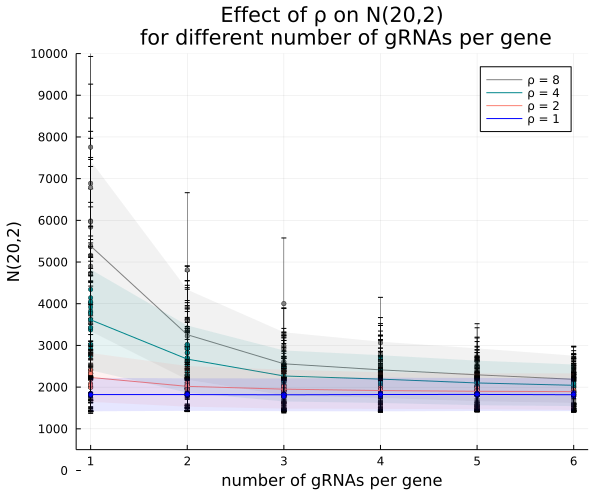

In [21]:
markersize = 2.5
markerstrokewidth=0.4

scatter(1:6, Es_p8_bioccp', errorbar=sds_p8_bioccp', color=:grey, label="",markersize=markersize, 
    markerstrokewidth=markerstrokewidth)
plot!(1:6, mean(Es_p8_bioccp, dims=1)[:], color=:grey, ribbon=mean(sds_p8_bioccp, dims=1)[:],fillalpha=.1,
size = ((850,600)),label="ρ = 8", ylim=(500,10000),
xlabel="number of gRNAs per gene", ylabel="N(20,2)", title="Effect of ρ on N(20,2)
    for different number of gRNAs per gene")


scatter!(1:6, Es_p4_bioccp', errorbar=sds_p4_bioccp', color=:turquoise4, label="",markersize=markersize, markerstrokewidth=markerstrokewidth)
plot!(1:6, mean(Es_p4_bioccp, dims=1)[:], color=:turquoise4, ribbon=mean(sds_p4_bioccp, dims=1)[:],  fillalpha=.1,
     yticks = (0:1000:10000, string.(0:1000:10000)),label="ρ = 4")

scatter!(1:6, Es_p2_bioccp', errorbar=sds_p2_bioccp', color=:salmon, label="", markersize=markersize, markerstrokewidth=markerstrokewidth)
plot!(1:6, mean(Es_p2_bioccp, dims=1)[:], color=:salmon, ribbon=mean(sds_p2_bioccp, dims=1)[:],  fillalpha=.1, label="ρ = 2")

scatter!(1:6, Es_p1_bioccp', errorbar=sds_p1_bioccp', color=:blue, label="", markersize=markersize, markerstrokewidth=markerstrokewidth ) #, markeralpha=0)
plot!(1:6, mean(Es_p1_bioccp, dims=1)[:], color=:blue, ribbon=mean(sds_p1_bioccp, dims=1)[:],  fillalpha=.1,
size = ((600,500)),label="ρ = 1")


In [705]:
iter = 15

# f7
### vary number of gRNAs per gene
Es_f7_bioccp = zeros(iter, 6)
sds_f7_bioccp = zeros(iter, 6) 

for i in 1:iter
    for gRNA_pergene in 1:6
    gRNA_total = targets*gRNA_pergene
    d = ones(gRNA_total)/gRNA_total
    p_high_activity = 0.7
    μ_high_activity = 0.9;     μ_low_activity = 0.1; σ_activity = 0.01
    d_act = gRNA_activity_distribution(p_high_activity, μ_high_activity, μ_low_activity, σ_activity, gRNA_total; visualize=false);  

    E, sd = simulate_Nₓ₂(targets, 
                              gRNA_pergene, 
                              gRNA_perconstruct, 
                              gRNA_total, 
                              d, 
                              d_act, ϵ)
    Es_f7_bioccp[i,gRNA_pergene] = E
    sds_f7_bioccp[i,gRNA_pergene] = sd
    end
end

## f8
### vary number of gRNAs per gene
Es_f8_bioccp = zeros(iter, 6)
sds_f8_bioccp = zeros(iter, 6) 
for i in 1:iter
    for gRNA_pergene in 1:6
    gRNA_total = targets*gRNA_pergene
    d = ones(gRNA_total)/gRNA_total
    p_high_activity = 0.8
    μ_high_activity = 0.9;     μ_low_activity = 0.1;     σ_activity = 0.01
    d_act = gRNA_activity_distribution(p_high_activity, μ_high_activity, μ_low_activity, σ_activity, gRNA_total; visualize=false);  
    E, sd = simulate_Nₓ₂(targets, 
                              gRNA_pergene, 
                              gRNA_perconstruct, 
                              gRNA_total, 
                              d, 
                              d_act, ϵ)
    Es_f8_bioccp[i,gRNA_pergene] = E
    sds_f8_bioccp[i,gRNA_pergene] = sd
    end
end

##f9 
### vary number of gRNAs per gene
Es_f9_bioccp = zeros(iter, 6)
sds_f9_bioccp = zeros(iter, 6) 
for i in 1:iter
    for gRNA_pergene in 1:6
    gRNA_total = targets*gRNA_pergene
    d = ones(gRNA_total)/gRNA_total
    p_high_activity = 0.9
    μ_high_activity = 0.9
    μ_low_activity = 0.1
    σ_activity = 0.01
    d_act = gRNA_activity_distribution(p_high_activity, μ_high_activity, μ_low_activity, σ_activity, gRNA_total; visualize=false);  

    E, sd = simulate_Nₓ₂(targets, 
                              gRNA_pergene, 
                              gRNA_perconstruct, 
                              gRNA_total, 
                              d, 
                              d_act, ϵ)
    Es_f9_bioccp[i,gRNA_pergene] = E
    sds_f9_bioccp[i,gRNA_pergene] = sd
    end
end


##f1
 
### vary number of gRNAs per gene
Es_f1_bioccp = zeros(iter, 6)
sds_f1_bioccp = zeros(iter, 6) 
for i in 1:iter
    for gRNA_pergene in 1:6
    gRNA_total = targets*gRNA_pergene
    d = ones(gRNA_total)/gRNA_total
    p_high_activity = 1
    μ_high_activity = 0.9
    μ_low_activity = 0.1
    σ_activity = 0.01
    d_act = gRNA_activity_distribution(p_high_activity, μ_high_activity, μ_low_activity, σ_activity, gRNA_total; visualize=false);  

    E, sd = simulate_Nₓ₂(targets, 
                              gRNA_pergene, 
                              gRNA_perconstruct, 
                              gRNA_total, 
                              d, 
                              d_act, ϵ)
    Es_f1_bioccp[i,gRNA_pergene] = E
    sds_f1_bioccp[i,gRNA_pergene] = sd
    end
end

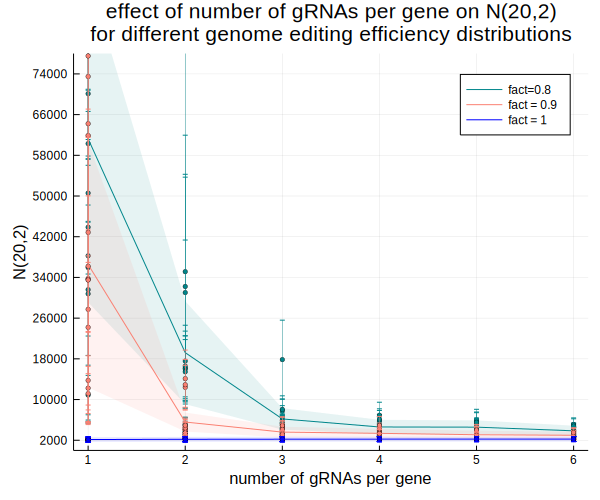

In [743]:
markersize = 2.5
markerstrokewidth=0.4

scatter(1:6, Es_f8_bioccp', errorbar=sds_f8_bioccp', color=:turquoise4, label="",markersize=markersize, markerstrokewidth=markerstrokewidth)
plot!(1:6, mean(Es_f8_bioccp, dims=1)[:], color=:turquoise4, ribbon=mean(sds_f8_bioccp, dims=1)[:],  fillalpha=.1,
     yticks = (2000:8000:78000, string.(2000:8000:78000)),
    label="fact=0.8",
        ylim=(0,78000),
xlabel="number of gRNAs per gene", ylabel="N(20,2)", title="effect of number of gRNAs per gene on N(20,2)
    for different genome editing efficiency distributions")

scatter!(1:6, Es_f9_bioccp', errorbar=sds_f9_bioccp', color=:salmon, label="", markersize=markersize, markerstrokewidth=markerstrokewidth)
plot!(1:6, mean(Es_f9_bioccp, dims=1)[:], color=:salmon, ribbon=mean(sds_f9_bioccp, dims=1)[:],  fillalpha=.1, label="fact = 0.9")

scatter!(1:6, Es_f1_bioccp', errorbar=sds_f1_bioccp', color=:blue, label="", markersize=markersize, markerstrokewidth=markerstrokewidth ) #, markeralpha=0)
plot!(1:6, mean(Es_f1_bioccp, dims=1)[:], color=:blue, ribbon=mean(sds_f1_bioccp, dims=1)[:],  fillalpha=.1,
size = ((600,500)),label="fact = 1")

In [37]:
using BioCCP 

function BioCCP_Pₓ₂(n_targets, sample_size,
                                         n_gRNA_pergene, 
                                         n_gRNA_perconstruct, 
                                         n_gRNA_total, 
                                         p_gRNA_library, 
                                         p_gRNA_act, ϵ_knockout_global)
    
    # how many pairwise combinations of gRNAs
    ind_combinations_gRNA = collect(combinations(1:n_gRNA_total, 2))
    n_combinations_gRNA = length(ind_combinations_gRNA)
    
    # calculate probability and activity of gRNA combinations
    p_combinations_gRNA_library = zeros(n_combinations_gRNA)
    p_combinations_gRNA_act = zeros(n_combinations_gRNA)
    for i in 1:n_combinations_gRNA
        p_combinations_gRNA_library[i] = p_gRNA_library[ind_combinations_gRNA[i][1]] * p_gRNA_library[ind_combinations_gRNA[i][2]]
        p_combinations_gRNA_act[i] = p_gRNA_act[ind_combinations_gRNA[i][1]] * p_gRNA_act[ind_combinations_gRNA[i][2]]
    end
    
    # normalize probability gRNA combinations
    p_combinations_gRNA_library /= sum(p_combinations_gRNA_library)

    # select pairwise gRNA combinations of which each component codes for different gene (goal is to study combinations of knockouts in different genes)
    p_combinations_gRNA_library_interest = []
    p_combinations_gRNA_act_interest = []
    ind_combinations_gRNA_interest = []
    for i in 1:n_combinations_gRNA
        if ceil(ind_combinations_gRNA[i][1]/n_gRNA_pergene) != ceil(ind_combinations_gRNA[i][2]/n_gRNA_pergene)
            push!(p_combinations_gRNA_library_interest, p_combinations_gRNA_library[i])
            push!(p_combinations_gRNA_act_interest, p_combinations_gRNA_act[i])
            push!(ind_combinations_gRNA_interest, ind_combinations_gRNA[i])
        end
    end
        
    n_combinations_gRNA_interest = length(p_combinations_gRNA_library_interest)
    p_combinations_gRNA = p_combinations_gRNA_library_interest .* p_combinations_gRNA_act_interest * ϵ_knockout_global^2

    #### INTEGREREN PER GENCOMBINATIE
    p_genes_matrix = zeros(n_targets, n_targets)
    for i in 1:n_combinations_gRNA_interest
        gene1 = Int(ceil(ind_combinations_gRNA_interest[i][1]/n_gRNA_pergene))
        gene2 = Int(ceil(ind_combinations_gRNA_interest[i][2]/n_gRNA_pergene))
        p_genes_matrix[gene1, gene2] += p_combinations_gRNA[i]
    end

    p_genes = collect([p_genes_matrix[i, j] for j in 2:size(p_genes_matrix, 1) for i in 1:j-1])  
    n_combinations_genes = length(p_genes)
    combinations_pp = length(collect(combinations(1:n_gRNA_perconstruct, 2)))
    
    return success_probability(n_combinations_genes, sample_size; p=p_genes, r=combinations_pp, normalize=false)
end

BioCCP_Pₓ₂ (generic function with 1 method)

In [24]:
### using BioCCP

function BioCCP_Pₓ₁(n_targets, sample_size,
                                         n_gRNA_pergene, 
                                         n_gRNA_perconstruct, 
                                         n_gRNA_total, 
                                         p_gRNA_library, 
                                         p_gRNA_act, ϵ_knockout_global)
    
    p_gRNAs = p_gRNA_library .* p_gRNA_act * ϵ_knockout_global
    p_genes = [sum(p_gRNAs[i:i+n_gRNA_pergene-1]) for i in 1:n_gRNA_pergene:n_gRNA_total]
    return success_probability(n_targets, sample_size; p=p_genes, r=n_gRNA_perconstruct, normalize=false) 
end

BioCCP_Pₓ₁ (generic function with 1 method)

In [23]:
using BioCCP 

function BioCCP_γₓ₂(n_targets, sample_size,
                                         n_gRNA_pergene, 
                                         n_gRNA_perconstruct, 
                                         n_gRNA_total, 
                                         p_gRNA_library, 
                                         p_gRNA_act, ϵ_knockout_global)
    
    # how many pairwise combinations of gRNAs
    ind_combinations_gRNA = collect(combinations(1:n_gRNA_total, 2))
    n_combinations_gRNA = length(ind_combinations_gRNA)
    
    # calculate probability and activity of gRNA combinations
    p_combinations_gRNA_library = zeros(n_combinations_gRNA)
    p_combinations_gRNA_act = zeros(n_combinations_gRNA)
    for i in 1:n_combinations_gRNA
        p_combinations_gRNA_library[i] = p_gRNA_library[ind_combinations_gRNA[i][1]] * p_gRNA_library[ind_combinations_gRNA[i][2]]
        p_combinations_gRNA_act[i] = p_gRNA_act[ind_combinations_gRNA[i][1]] * p_gRNA_act[ind_combinations_gRNA[i][2]]
    end
    
    # normalize probability gRNA combinations
    p_combinations_gRNA_library /= sum(p_combinations_gRNA_library)

    # select pairwise gRNA combinations of which each component codes for different gene (goal is to study combinations of knockouts in different genes)
    p_combinations_gRNA_library_interest = []
    p_combinations_gRNA_act_interest = []
    ind_combinations_gRNA_interest = []
    for i in 1:n_combinations_gRNA
        if ceil(ind_combinations_gRNA[i][1]/n_gRNA_pergene) != ceil(ind_combinations_gRNA[i][2]/n_gRNA_pergene)
            push!(p_combinations_gRNA_library_interest, p_combinations_gRNA_library[i])
            push!(p_combinations_gRNA_act_interest, p_combinations_gRNA_act[i])
            push!(ind_combinations_gRNA_interest, ind_combinations_gRNA[i])
        end
    end
        
    n_combinations_gRNA_interest = length(p_combinations_gRNA_library_interest)
    p_combinations_gRNA = p_combinations_gRNA_library_interest .* p_combinations_gRNA_act_interest * ϵ_knockout_global^2

    #### INTEGREREN PER GENCOMBINATIE
    p_genes_matrix = zeros(n_targets, n_targets)
    for i in 1:n_combinations_gRNA_interest
        gene1 = Int(ceil(ind_combinations_gRNA_interest[i][1]/n_gRNA_pergene))
        gene2 = Int(ceil(ind_combinations_gRNA_interest[i][2]/n_gRNA_pergene))
        p_genes_matrix[gene1, gene2] += p_combinations_gRNA[i]
    end

    p_genes = collect([p_genes_matrix[i, j] for j in 2:size(p_genes_matrix, 1) for i in 1:j-1])  
    n_combinations_genes = length(p_genes)
    combinations_pp = length(collect(combinations(1:n_gRNA_perconstruct, 2)))
    
    return expectation_fraction_collected(n_combinations_genes, sample_size; p=p_genes, r=combinations_pp, normalize=false)
end

BioCCP_γₓ₂ (generic function with 1 method)

In [22]:
using BioCCP

function BioCCP_γₓ₁(n_targets, sample_size,
                                         n_gRNA_pergene, 
                                         n_gRNA_perconstruct, 
                                         n_gRNA_total, 
                                         p_gRNA_library, 
                                         p_gRNA_act, ϵ_knockout_global)
    
    p_gRNAs = p_gRNA_library .* p_gRNA_act * ϵ_knockout_global
    p_genes = [sum(p_gRNAs[i:i+n_gRNA_pergene-1]) for i in 1:n_gRNA_pergene:n_gRNA_total]
    return expectation_fraction_collected(n_targets, sample_size; p=p_genes, r=n_gRNA_perconstruct, normalize=false) 
end

BioCCP_γₓ₁ (generic function with 1 method)

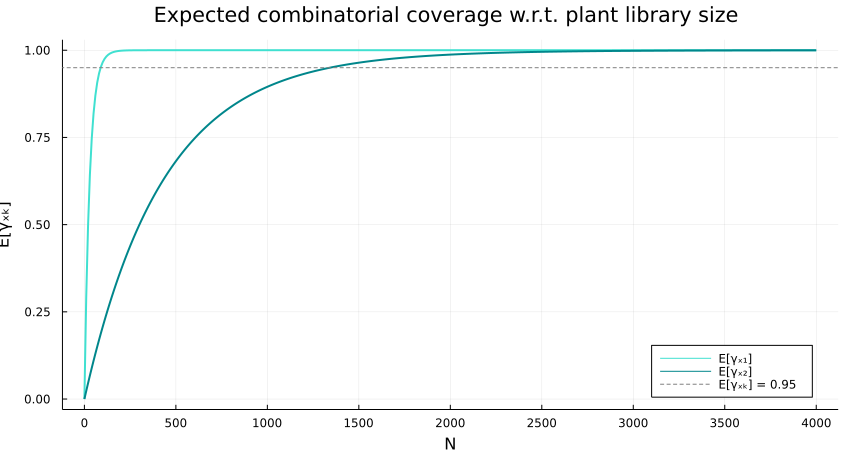

In [35]:
n_targets = 20
n_gRNA_pergene = 6
n_gRNA_total = targets * gRNA_pergene
Random.seed!(1)
p_high_activity = 0.9
μ_high_activity = 0.9
μ_low_activity = 0.1
σ_activity = 0.01
p_gRNA_act = gRNA_activity_distribution(p_high_activity, μ_high_activity, μ_low_activity, σ_activity, gRNA_total; visualize=false); 
ϵ_knockout_global = 0.8

ρ  = 2
l = 50
u = 50*ρ 
m= (l+u)/2
sd = (u-l)/2
Random.seed!(1)
p_gRNA_library = gRNA_frequency_distribution(m, sd, l, u, gRNA_total; normalize = true, visualize=false)


sample_sizes = 0:10:4000
expected_fraction_pairwise = []
expected_fraction_single = []


for sample_size in sample_sizes
    n_gRNA_perconstruct = 2
    push!(expected_fraction_pairwise, BioCCP_γₓ₂(n_targets, sample_size,
                                         n_gRNA_pergene, 
                                         n_gRNA_perconstruct, 
                                         n_gRNA_total, 
                                         p_gRNA_library, 
                                         p_gRNA_act, ϵ_knockout_global))
    
    n_gRNA_perconstruct = 1
    push!(expected_fraction_single, BioCCP_γₓ₁(n_targets, sample_size,
                                         n_gRNA_pergene, 
                                         n_gRNA_perconstruct, 
                                         n_gRNA_total, 
                                         p_gRNA_library, 
                                         p_gRNA_act, ϵ_knockout_global))
end
 
plot(sample_sizes, expected_fraction_single, label="E[γₓ₁]", color=:turquoise, linewidth=2)

plot!(sample_sizes, expected_fraction_pairwise,
label="E[γₓ₂]", title="Expected combinatorial coverage w.r.t. plant library size 
    ",
xlabel="N", ylabel="E[γₓₖ]", 
        xticks = (0:500:50000, string.(0:500:50000)),
 size=(850,450), color=:turquoise4, linewidth=2)
hline!([0.95], linestyle=:dash, color=:grey, label="E[γₓₖ] = 0.95", legend=:bottomright)

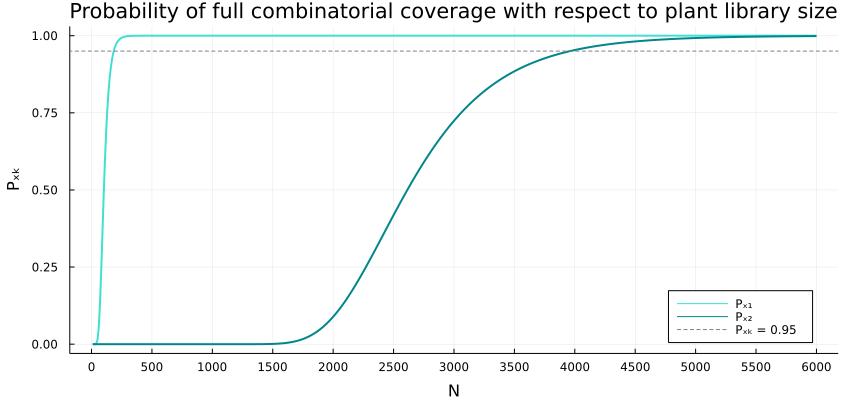

In [44]:
targets = 20
n_gRNA_pergene = 6
n_gRNA_total = targets * gRNA_pergene
Random.seed!(1)
p_high_activity = 0.9
μ_high_activity = 0.9
μ_low_activity = 0.1
σ_activity = 0.01
Random.seed!(1)
p_gRNA_act = gRNA_activity_distribution(p_high_activity, μ_high_activity, μ_low_activity, σ_activity, gRNA_total; visualize=false); 
ϵ_knockout_global = 0.8

ρ  = 2
l = 50
u = 50*ρ 
m= (l+u)/2
sd = (u-l)/2
Random.seed!(1)
p_gRNA_library = gRNA_frequency_distribution(m, sd, l, u, gRNA_total; normalize = true, visualize=false)


sample_sizes = 0:10:6000
p_success_pairwise = []
p_success_single = []

for sample_size in sample_sizes
    n_gRNA_perconstruct = 2
    push!(p_success_pairwise, BioCCP_Pₓ₂(n_targets, sample_size,
                                         n_gRNA_pergene, 
                                         n_gRNA_perconstruct, 
                                         n_gRNA_total, 
                                         p_gRNA_library, 
                                         p_gRNA_act, ϵ_knockout_global))
    
    n_gRNA_perconstruct = 1
    push!(p_success_single, BioCCP_Pₓ₁(n_targets, sample_size,
                                         n_gRNA_pergene, 
                                         n_gRNA_perconstruct, 
                                         n_gRNA_total, 
                                         p_gRNA_library, 
                                         p_gRNA_act, ϵ_knockout_global))
end
 
plot(sample_sizes, p_success_single, label="Pₓ₁", color=:turquoise, linewidth=2)

plot!(sample_sizes, p_success_pairwise,
label="Pₓ₂", title="Probability of full combinatorial coverage with respect to plant library size",
xlabel="N
    ", ylabel="
    Pₓₖ", 
        xticks = (0:500:50000, string.(0:500:50000)),
 size=(850,400), color=:turquoise4, linewidth=2)
hline!([0.95], linestyle=:dash, color=:grey, label="Pₓₖ = 0.95", legend=:bottomright)

### 2.1.1 VARY NUMBER OF TARGET GENES

In [71]:
n_targets = 20
n_gRNA_pergene = 6
n_gRNA_total = n_targets * n_gRNA_pergene
ϵ_knockout_global = 0.8
ρ = 2
l = 50; 
u = ρ*l
m= (l+u)/2; 
sd= (u-l)/2; 
Random.seed!(1)
p_gRNA_library = gRNA_frequency_distribution(m, sd, l, u, n_gRNA_total; normalize=true)


Random.seed!(1)
p_active = 0.9; high_activity = 0.9; low_activity = 0.1; sd_act = 0.01
p_gRNA_act = gRNA_activity_distribution(p_active, high_activity, low_activity, sd_act, n_gRNA_total; visualize=false);

In [56]:
n_gRNA_perconstruct = 1
Random.seed!(1)
@time simulate_Nₓ₁(n_targets, 
                                n_gRNA_pergene, 
                                n_gRNA_perconstruct, 
                                n_gRNA_total, 
                                p_gRNA_library, 
                                p_gRNA_act, ϵ_knockout_global; iter=500)

  0.246234 seconds (1.41 M allocations: 214.099 MiB, 12.01% gc time)


(107.798, 35.021567875137535)

In [57]:
Random.seed!(1)
@time BioCCP_Nₓ₁(n_targets, 
                                n_gRNA_pergene, 
                                n_gRNA_perconstruct, 
                                n_gRNA_total, 
                                p_gRNA_library, 
                                p_gRNA_act, ϵ_knockout_global)

  0.001534 seconds (40 allocations: 19.000 KiB)


(110, 38)

In [59]:
n_gRNA_perconstruct = 2
Random.seed!(1)
@time simulate_Nₓ₂(n_targets, 
                                n_gRNA_pergene, 
                                n_gRNA_perconstruct, 
                                n_gRNA_total, 
                                p_gRNA_library, 
                                p_gRNA_act, ϵ_knockout_global; iter=500)

Iteration: 100 ... Calculating minimum number of plants ... 

Iteration: 200 ... Calculating minimum number of plants ... 

Iteration: 300 ... Calculating minimum number of plants ... 

Iteration: 400 ... Calculating minimum number of plants ... 

Iteration: 500 ... Calculating minimum number of plants ... 

  5.803687 seconds (21.82 M allocations: 6.924 GiB, 9.56% gc time, 0.11% compilation time)


(2785.95, 653.5562769297134)

In [65]:
Random.seed!(1)
@time BioCCP_Nₓ₂(n_targets, 
                                n_gRNA_pergene, 
                                n_gRNA_perconstruct, 
                                n_gRNA_total, 
                                p_gRNA_library, 
                                p_gRNA_act, ϵ_knockout_global)

  0.165518 seconds (471.62 k allocations: 23.081 MiB, 86.49% compilation time)


(2731, 641)

In [67]:
n_gRNA_perconstruct = 3
Random.seed!(1)
@time simulate_Nₓ₃(n_targets, 
                                n_gRNA_pergene, 
                                n_gRNA_perconstruct, 
                                n_gRNA_total, 
                                p_gRNA_library, 
                                p_gRNA_act, ϵ_knockout_global; iter=500)

Iteration: 100 ... Calculating minimum number of plants ... 

Iteration: 200 ... Calculating minimum number of plants ... 

Iteration: 300 ... Calculating minimum number of plants ... 

Iteration: 400 ... Calculating minimum number of plants ... 

Iteration: 500 ... Calculating minimum number of plants ... 

377.660286 seconds (315.16 M allocations: 1.141 TiB, 16.93% gc time, 0.10% compilation time)


(37961.906, 7183.905227227848)

In [70]:
n_gRNA_perconstruct = 3
Random.seed!(1)
@time BioCCP_Nₓ₃(n_targets, 
                                n_gRNA_pergene, 
                                n_gRNA_perconstruct, 
                                n_gRNA_total, 
                                p_gRNA_library, 
                                p_gRNA_act, ϵ_knockout_global)

  2.331204 seconds (69.15 M allocations: 1.161 GiB, 11.71% gc time, 27.56% compilation time)


(36771, 6989)

In [72]:
### N = 10
n_targets = 10
n_gRNA_total = n_targets * n_gRNA_pergene
n_gRNA_perconstruct = 1
ϵ_knockout_global = 0.8
Random.seed!(1)
p_gRNA_library = gRNA_frequency_distribution(m, sd, l, u, n_gRNA_total; normalize=true)
Random.seed!(1)
p_gRNA_act = gRNA_activity_distribution(p_active, high_activity, low_activity, sd_act, n_gRNA_total; visualize=false) 

E_10_sim_single, sd_10_sim_single = simulate_Nₓ₁(n_targets, 
                                n_gRNA_pergene, 
                                n_gRNA_perconstruct, 
                                n_gRNA_total, 
                                p_gRNA_library, 
                                p_gRNA_act, ϵ_knockout_global; iter=500)

E_10_bioccp_single, sd_10_bioccp_single = BioCCP_Nₓ₁(n_targets, 
                              n_gRNA_pergene, 
                              n_gRNA_perconstruct, 
                              n_gRNA_total, 
                              p_gRNA_library, 
                              p_gRNA_act, ϵ_knockout_global)

### N = 20
n_targets = 20
n_gRNA_total = n_targets * n_gRNA_pergene
Random.seed!(1)
p_gRNA_library = gRNA_frequency_distribution(m, sd, l, u, n_gRNA_total; normalize=true)
Random.seed!(1)
p_gRNA_act = gRNA_activity_distribution(p_active, high_activity, low_activity, sd_act, n_gRNA_total; visualize=false) 

E_20_sim_single, sd_20_sim_single = simulate_Nₓ₁(n_targets, 
                                n_gRNA_pergene, 
                                n_gRNA_perconstruct, 
                                n_gRNA_total, 
                                p_gRNA_library, 
                                p_gRNA_act, ϵ_knockout_global; iter=500)

E_20_bioccp_single, sd_20_bioccp_single = BioCCP_Nₓ₁(n_targets, 
                              n_gRNA_pergene, 
                              n_gRNA_perconstruct, 
                              n_gRNA_total, 
                              p_gRNA_library, 
                              p_gRNA_act, ϵ_knockout_global)

### N = 30
n_targets = 30
n_gRNA_total = n_targets * n_gRNA_pergene
Random.seed!(1)
p_gRNA_library = gRNA_frequency_distribution(m, sd, l, u, n_gRNA_total; normalize=true)
Random.seed!(1)
p_gRNA_act = gRNA_activity_distribution(p_active, high_activity, low_activity, sd_act, n_gRNA_total; visualize=false) 

E_30_sim_single, sd_30_sim_single = simulate_Nₓ₁(n_targets, 
                                n_gRNA_pergene, 
                                n_gRNA_perconstruct, 
                                n_gRNA_total, 
                                p_gRNA_library, 
                                p_gRNA_act, ϵ_knockout_global; iter=500)

E_30_bioccp_single, sd_30_bioccp_single = BioCCP_Nₓ₁(n_targets, 
                              n_gRNA_pergene, 
                              n_gRNA_perconstruct, 
                              n_gRNA_total, 
                              p_gRNA_library, 
                              p_gRNA_act, ϵ_knockout_global)

### N = 40
n_targets = 40
n_gRNA_total = n_targets * n_gRNA_pergene
Random.seed!(1)
p_gRNA_library = gRNA_frequency_distribution(m, sd, l, u, n_gRNA_total; normalize=true)
Random.seed!(1)
p_gRNA_act = gRNA_activity_distribution(p_active, high_activity, low_activity, sd_act, n_gRNA_total; visualize=false) 

E_40_sim_single, sd_40_sim_single = simulate_Nₓ₁(n_targets, 
                                n_gRNA_pergene, 
                                n_gRNA_perconstruct, 
                                n_gRNA_total, 
                                p_gRNA_library, 
                                p_gRNA_act, ϵ_knockout_global; iter=500)

E_40_bioccp_single, sd_40_bioccp_single = BioCCP_Nₓ₁(n_targets, 
                              n_gRNA_pergene, 
                              n_gRNA_perconstruct, 
                              n_gRNA_total, 
                              p_gRNA_library, 
                              p_gRNA_act, ϵ_knockout_global)

### N = 50
n_targets = 50
n_gRNA_total = n_targets * n_gRNA_pergene
Random.seed!(1)
p_gRNA_library = gRNA_frequency_distribution(m, sd, l, u, n_gRNA_total; normalize=true)
Random.seed!(1)
p_gRNA_act = gRNA_activity_distribution(p_active, high_activity, low_activity, sd_act, n_gRNA_total; visualize=false) 

E_50_sim_single, sd_50_sim_single = simulate_Nₓ₁(n_targets, 
                                n_gRNA_pergene, 
                                n_gRNA_perconstruct, 
                                n_gRNA_total, 
                                p_gRNA_library, 
                                p_gRNA_act, ϵ_knockout_global; iter=500)

E_50_bioccp_single, sd_50_bioccp_single = BioCCP_Nₓ₁(n_targets, 
                              n_gRNA_pergene, 
                              n_gRNA_perconstruct, 
                              n_gRNA_total, 
                              p_gRNA_library, 
                              p_gRNA_act, ϵ_knockout_global)

(349, 103)

In [73]:
E_targets_sim_single = [E_10_sim_single, E_20_sim_single, E_30_sim_single, E_40_sim_single, E_50_sim_single]
E_targets_bioccp_single = [E_10_bioccp_single, E_20_bioccp_single, E_30_bioccp_single, E_40_bioccp_single, E_50_bioccp_single]
sd_targets_sim_single = [sd_10_sim_single, sd_20_sim_single, sd_30_sim_single, sd_40_sim_single, sd_50_sim_single]
sd_targets_bioccp_single = [sd_10_bioccp_single, sd_20_bioccp_single, sd_30_bioccp_single, sd_40_bioccp_single, sd_50_bioccp_single];

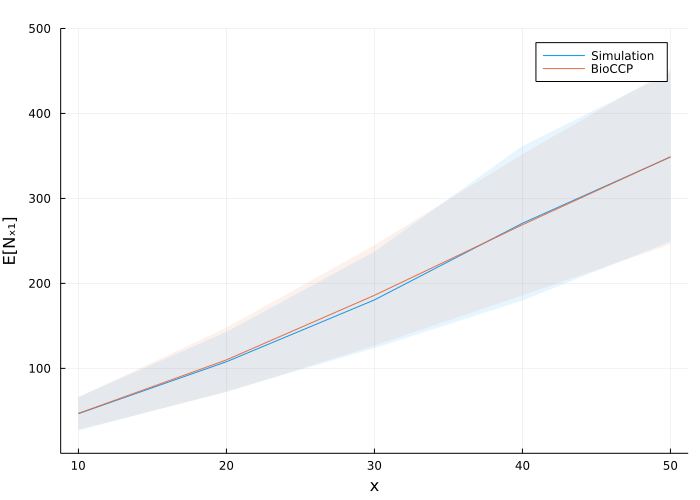

In [85]:
plot(collect(10:10:50), E_targets_sim_single, label="Simulation", 
    title="     ", xlabel="x", ylabel="E[Nₓ₁]",
    ribbon = sd_targets_sim_single, fillalpha=.1,
    xticks = (10:10:50, string.(10:10:50)),
    yticks = (100:100:600, string.(100:100:600)),
    ylim=(0, 500),
size = ((700,500)),
titlefont=font(11),
guidefontsize =11, guidefontfamily=101)

plot!(collect(10:10:50), E_targets_bioccp_single,  label="BioCCP",
    ribbon = sd_targets_bioccp_single, 
    fillalpha=.1,
)

#### 2.1.4 KNOCKOUT EFFICIENCY

In [86]:
n_targets = 20
n_gRNA_pergene = 6
n_gRNA_total= n_targets * n_gRNA_pergene
n_gRNA_perconstruct = 1
p_active = 0.9; high_activity = 0.9; low_activity = 0.1; sd_act = 0.01
Random.seed!(1)
p_gRNA_act = gRNA_activity_distribution(p_active, high_activity, low_activity, sd_act, n_gRNA_total; visualize=false) ;
ρ = 2 
l = 50
u = ρ*l 
m= (l+u)/2
sd= (u-l)/2
Random.seed!(1)
p_gRNA_lib = gRNA_frequency_distribution(m, sd, l, u, n_gRNA_total; normalize=true);

In [87]:
## 70
ϵ_knockout_global = 0.7

E_p_KO70_bioccp_single, sd_p_KO70_bioccp_single = BioCCP_Nₓ₁(n_targets, 
                              n_gRNA_pergene, 
                              n_gRNA_perconstruct, 
                              n_gRNA_total, 
                              p_gRNA_lib, 
                              p_gRNA_act, ϵ_knockout_global)

E_p_KO70_sim_single, sd_p_KO70_sim_single = simulate_Nₓ₁(n_targets, 
                                n_gRNA_pergene, 
                                n_gRNA_perconstruct, 
                                n_gRNA_total, 
                                p_gRNA_lib, 
                                p_gRNA_act, ϵ_knockout_global; iter=500)

## 80
ϵ_knockout_global = 0.8

E_p_KO80_bioccp_single, sd_p_KO80_bioccp_single = BioCCP_Nₓ₁(n_targets, 
                              n_gRNA_pergene, 
                              n_gRNA_perconstruct, 
                              n_gRNA_total, 
                              p_gRNA_lib, 
                              p_gRNA_act, ϵ_knockout_global)

E_p_KO80_sim_single, sd_p_KO80_sim_single = simulate_Nₓ₁(n_targets, 
                                n_gRNA_pergene, 
                                n_gRNA_perconstruct, 
                                n_gRNA_total, 
                                p_gRNA_lib, 
                                p_gRNA_act, ϵ_knockout_global; iter=500)

## 90
ϵ_knockout_global = 0.9

E_p_KO90_bioccp_single, sd_p_KO90_bioccp_single = BioCCP_Nₓ₁(n_targets, 
                              n_gRNA_pergene, 
                              n_gRNA_perconstruct, 
                              n_gRNA_total, 
                              p_gRNA_lib, 
                              p_gRNA_act, ϵ_knockout_global)

E_p_KO90_sim_single, sd_p_KO90_sim_single = simulate_Nₓ₁(n_targets, 
                                n_gRNA_pergene, 
                                n_gRNA_perconstruct, 
                                n_gRNA_total, 
                                p_gRNA_lib, 
                                p_gRNA_act, ϵ_knockout_global; iter=500)
## 100
ϵ_knockout_global = 1

E_p_KO100_bioccp_single, sd_p_KO100_bioccp_single = BioCCP_Nₓ₁(n_targets, 
                              n_gRNA_pergene, 
                              n_gRNA_perconstruct, 
                              n_gRNA_total, 
                              p_gRNA_lib, 
                              p_gRNA_act, ϵ_knockout_global)

E_p_KO100_sim_single, sd_p_KO100_sim_single = simulate_Nₓ₁(n_targets, 
                                n_gRNA_pergene, 
                                n_gRNA_perconstruct, 
                                n_gRNA_total, 
                                p_gRNA_lib, 
                                p_gRNA_act, ϵ_knockout_global; iter=500)

(89.192, 32.07204964977255)

In [88]:
E_p_KO_sim_single = [E_p_KO70_sim_single, E_p_KO80_sim_single, E_p_KO90_sim_single,E_p_KO100_sim_single]
E_p_KO_bioccp_single = [E_p_KO70_bioccp_single, E_p_KO80_bioccp_single, E_p_KO90_bioccp_single, E_p_KO100_bioccp_single]
sd_p_KO_sim_single = [sd_p_KO70_sim_single, sd_p_KO80_sim_single, sd_p_KO90_sim_single,sd_p_KO100_sim_single]
sd_p_KO_bioccp_single = [sd_p_KO70_bioccp_single, sd_p_KO80_bioccp_single, sd_p_KO90_bioccp_single, sd_p_KO100_bioccp_single]

4-element Vector{Int64}:
 44
 38
 34
 30

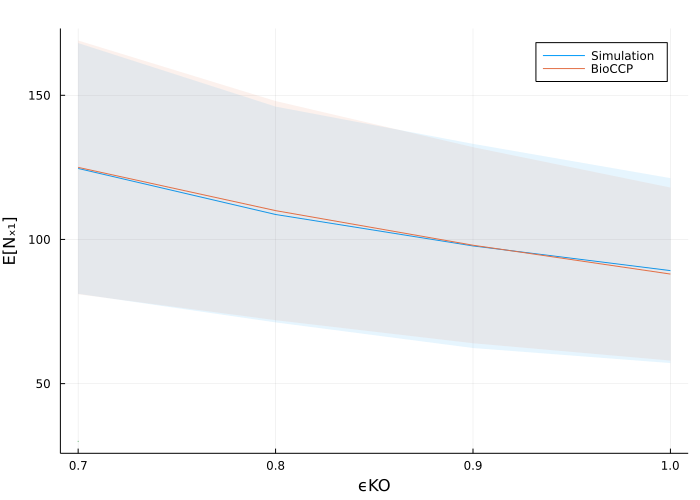

In [90]:
plot([0.7, 0.8, 0.9, 1], E_p_KO_sim_single, label="Simulation", 
    title="  ", xlabel="ϵKO", ylabel="E[Nₓ₁]",
    ribbon = sd_p_KO_sim_single, fillalpha=.1,
    xticks = ([0.7, 0.8, 0.9, 1], string.([0.7, 0.8, 0.9, 1])),
    yticks = (0:50:300, string.(0:50:300)),
size = ((700,500)),
titlefont=font(11),
guidefontsize =11, guidefontfamily=101)

plot!([0.7, 0.8, 0.9, 1], E_p_KO_bioccp_single,  label="BioCCP",
    ribbon = sd_p_KO_bioccp_single, 
    fillalpha=.1,
)

scatter!([0.7], [30], label="", markersize=0.00001)


### 2.2 How many plants necessary to see each pairwise combination of gene knockouts at least once?

In [93]:
n_gRNA_pergene = 6
n_gRNA_perconstruct = 2
ϵ_knockout_global = 0.8
ρ = 2
l = 50
u = ρ*l 
m= (l+u)/2
sd= (u-l)/2
p_active = 0.9; high_activity = 0.9; low_activity = 0.1; sd_act = 0.01;

In [94]:
### N = 10
n_targets = 10
n_gRNA_total = n_targets * n_gRNA_pergene
Random.seed!(1)
p_gRNA_library = gRNA_frequency_distribution(m, sd, l, u, n_gRNA_total; normalize=true)
Random.seed!(1)
p_gRNA_act = gRNA_activity_distribution(p_active, high_activity, low_activity, sd_act, n_gRNA_total; visualize=false) 

E_10_sim, sd_10_sim = simulate_Nₓ₂(n_targets, 
                                n_gRNA_pergene, 
                                n_gRNA_perconstruct, 
                                n_gRNA_total, 
                                p_gRNA_library, 
                                p_gRNA_act, ϵ_knockout_global; iter=500)

E_10_bioccp, sd_10_bioccp = BioCCP_Nₓ₂(n_targets, 
                              n_gRNA_pergene, 
                              n_gRNA_perconstruct, 
                              n_gRNA_total, 
                              p_gRNA_library, 
                              p_gRNA_act, ϵ_knockout_global)

### N = 20
n_targets = 20
n_gRNA_total = n_targets * n_gRNA_pergene
Random.seed!(1)
p_gRNA_library = gRNA_frequency_distribution(m, sd, l, u, n_gRNA_total; normalize=true)
Random.seed!(1)
p_gRNA_act = gRNA_activity_distribution(p_active, high_activity, low_activity, sd_act, n_gRNA_total; visualize=false) 

E_20_sim, sd_20_sim = simulate_Nₓ₂(n_targets, 
                                n_gRNA_pergene, 
                                n_gRNA_perconstruct, 
                                n_gRNA_total, 
                                p_gRNA_library, 
                                p_gRNA_act, ϵ_knockout_global; iter=500)

E_20_bioccp, sd_20_bioccp = BioCCP_Nₓ₂(n_targets, 
                              n_gRNA_pergene, 
                              n_gRNA_perconstruct, 
                              n_gRNA_total, 
                              p_gRNA_library, 
                              p_gRNA_act, ϵ_knockout_global)

### N = 30
n_targets = 30
n_gRNA_total = n_targets * n_gRNA_pergene
Random.seed!(1)
p_gRNA_library = gRNA_frequency_distribution(m, sd, l, u, n_gRNA_total; normalize=true)
Random.seed!(1)
p_gRNA_act = gRNA_activity_distribution(p_active, high_activity, low_activity, sd_act, n_gRNA_total; visualize=false) 

E_30_sim, sd_30_sim = simulate_Nₓ₂(n_targets, 
                                n_gRNA_pergene, 
                                n_gRNA_perconstruct, 
                                n_gRNA_total, 
                                p_gRNA_library, 
                                p_gRNA_act, ϵ_knockout_global; iter=500)

E_30_bioccp, sd_30_bioccp = BioCCP_Nₓ₂(n_targets, 
                              n_gRNA_pergene, 
                              n_gRNA_perconstruct, 
                              n_gRNA_total, 
                              p_gRNA_library, 
                              p_gRNA_act, ϵ_knockout_global)

### N = 40
n_targets = 40
n_gRNA_total = n_targets * n_gRNA_pergene
Random.seed!(80)
p_gRNA_library = gRNA_frequency_distribution(m, sd, l, u, n_gRNA_total; normalize=true)
p_gRNA_act = gRNA_activity_distribution(p_active, high_activity, low_activity, sd_act, n_gRNA_total; visualize=false) 

E_40_sim, sd_40_sim = simulate_Nₓ₂(n_targets, 
                                n_gRNA_pergene, 
                                n_gRNA_perconstruct, 
                                n_gRNA_total, 
                                p_gRNA_library, 
                                p_gRNA_act, ϵ_knockout_global; iter=500)

E_40_bioccp, sd_40_bioccp = BioCCP_Nₓ₂(n_targets, 
                              n_gRNA_pergene, 
                              n_gRNA_perconstruct, 
                              n_gRNA_total, 
                              p_gRNA_library, 
                              p_gRNA_act, ϵ_knockout_global)

### N = 50
n_targets = 50
n_gRNA_total = n_targets * n_gRNA_pergene
Random.seed!(1)
p_gRNA_library = gRNA_frequency_distribution(m, sd, l, u, n_gRNA_total; normalize=true)
Random.seed!(1)
p_gRNA_act = gRNA_activity_distribution(p_active, high_activity, low_activity, sd_act, n_gRNA_total; visualize=false) 

E_50_sim, sd_50_sim = simulate_Nₓ₂(n_targets, 
                                n_gRNA_pergene, 
                                n_gRNA_perconstruct, 
                                n_gRNA_total, 
                                p_gRNA_library, 
                                p_gRNA_act, ϵ_knockout_global; iter=500)

E_50_bioccp, sd_50_bioccp = BioCCP_Nₓ₂(n_targets, 
                              n_gRNA_pergene, 
                              n_gRNA_perconstruct, 
                              n_gRNA_total, 
                              p_gRNA_library, 
                              p_gRNA_act, ϵ_knockout_global)

Iteration: 100 ... Calculating minimum number of plants ... 

Iteration: 200 ... Calculating minimum number of plants ... 

Iteration: 300 ... Calculating minimum number of plants ... 

Iteration: 400 ... Calculating minimum number of plants ... 

Iteration: 500 ... Calculating minimum number of plants ... 

Iteration: 100 ... Calculating minimum number of plants ... 

Iteration: 200 ... Calculating minimum number of plants ... 

Iteration: 300 ... Calculating minimum number of plants ... 

Iteration: 400 ... Calculating minimum number of plants ... 

Iteration: 500 ... Calculating minimum number of plants ... 

Iteration: 100 ... Calculating minimum number of plants ... 

Iteration: 200 ... Calculating minimum number of plants ... 

Iteration: 300 ... Calculating minimum number of plants ... 

Iteration: 400 ... Calculating minimum number of plants ... 

Iteration: 500 ... Calculating minimum number of plants ... 

Iteration: 100 ... Calculating minimum number of plants ... 

Iteratio

(24397, 4627)

In [97]:
E_targets_sim = [E_10_sim, E_20_sim, E_30_sim, E_40_sim, E_50_sim]
E_targets_bioccp = [E_10_bioccp, E_20_bioccp, E_30_bioccp, E_40_bioccp, E_50_bioccp]
sd_targets_sim = [sd_10_sim, sd_20_sim, sd_30_sim, sd_40_sim, sd_50_sim]
sd_targets_bioccp = [sd_10_bioccp, sd_20_bioccp, sd_30_bioccp, sd_40_bioccp, sd_50_bioccp];

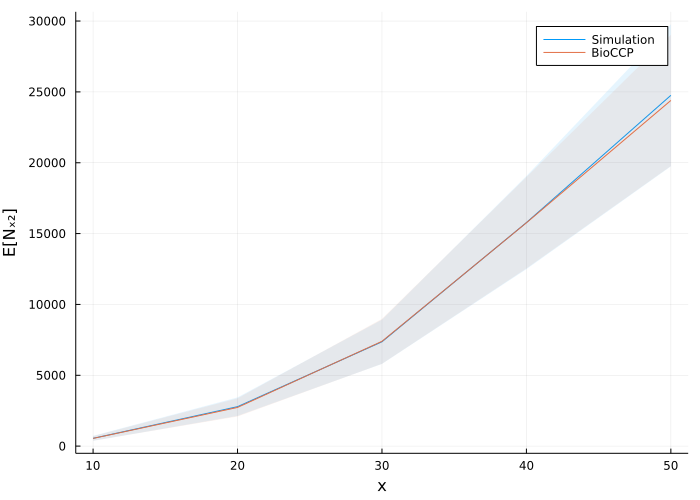

In [98]:
plot(collect(10:10:50), E_targets_sim, label="Simulation", 
    title="", xlabel="x", ylabel="E[Nₓ₂]",
    ribbon = sd_targets_sim, fillalpha=.1,
    xticks = (10:10:50, string.(10:10:50)),
    yticks = (0:5000:50000, string.(0:5000:50000)),
size = ((700,500)),
titlefont=font(11),
guidefontsize =11, guidefontfamily=101)

plot!(collect(10:10:50), E_targets_bioccp,  label="BioCCP",
    ribbon = sd_targets_bioccp, 
    fillalpha=.1,
)

##### Splitting

In [99]:
n_gRNA_pergene = 6
n_gRNA_perconstruct = 2
ϵ_knockout_global = 0.8

0.8

In [100]:
### N = 5
n_targets = 5
n_gRNA_total = n_targets * n_gRNA_pergene
ρ = 2
l = 50
u = ρ*l 
m= (l+u)/2
sd= (u-l)/2
Random.seed!(1)
p_gRNA_library = gRNA_frequency_distribution(m, sd, l, u, n_gRNA_total; normalize=true)
p_active = 0.9; high_activity = 0.9; low_activity = 0.1; sd_activity = 0.01
Random.seed!(1)
p_gRNA_act = gRNA_activity_distribution(p_active, high_activity, low_activity, sd_activity, n_gRNA_total; visualize=false) 

E_5_sim, sd_5_sim = simulate_Nₓ₂(n_targets, 
                                n_gRNA_pergene, 
                                n_gRNA_perconstruct, 
                                n_gRNA_total, 
                                p_gRNA_library, 
                                p_gRNA_act, ϵ_knockout_global; iter=500)

E_5_bioccp, sd_5_bioccp = BioCCP_Nₓ₂(n_targets, 
                              n_gRNA_pergene, 
                              n_gRNA_perconstruct, 
                              n_gRNA_total, 
                              p_gRNA_library, 
                              p_gRNA_act, ϵ_knockout_global)

### N = 10
n_targets = 10
n_gRNA_total = n_targets * n_gRNA_pergene
ρ = 2
l = 50
u = ρ*l 
m= (l+u)/2
sd= (u-l)/2
Random.seed!(1)
p_gRNA_library = gRNA_frequency_distribution(m, sd, l, u, n_gRNA_total; normalize=true)
p_active = 0.9; high_activity = 0.9; low_activity = 0.1; sd_activity = 0.01
Random.seed!(1)
p_gRNA_act = gRNA_activity_distribution(p_active, high_activity, low_activity, sd_activity, n_gRNA_total; visualize=false) 

E_10_sim, sd_10_sim = simulate_Nₓ₂(n_targets, 
                                n_gRNA_pergene, 
                                n_gRNA_perconstruct, 
                                n_gRNA_total, 
                                p_gRNA_library, 
                                p_gRNA_act, ϵ_knockout_global; iter=500)

E_10_bioccp, sd_10_bioccp = BioCCP_Nₓ₂(n_targets, 
                              n_gRNA_pergene, 
                              n_gRNA_perconstruct, 
                              n_gRNA_total, 
                              p_gRNA_library, 
                              p_gRNA_act, ϵ_knockout_global)

### N = 20
n_targets = 20
n_gRNA_total = n_targets * n_gRNA_pergene
ρ = 2
l = 50
u = ρ*l 
m= (l+u)/2
sd= (u-l)/2
Random.seed!(1)
p_gRNA_library = gRNA_frequency_distribution(m, sd, l, u, n_gRNA_total; normalize=true)
p_active = 0.9; high_activity = 0.9; low_activity = 0.1; sd_activity = 0.01
Random.seed!(1)
p_gRNA_act = gRNA_activity_distribution(p_active, high_activity, low_activity, sd_activity, n_gRNA_total; visualize=false) 


E_20_sim, sd_20_sim = simulate_Nₓ₂(n_targets, 
                                n_gRNA_pergene, 
                                n_gRNA_perconstruct, 
                                n_gRNA_total, 
                                p_gRNA_library, 
                                p_gRNA_act, ϵ_knockout_global; iter=500)

E_20_bioccp, sd_20_bioccp = BioCCP_Nₓ₂(n_targets, 
                              n_gRNA_pergene, 
                              n_gRNA_perconstruct, 
                              n_gRNA_total, 
                              p_gRNA_library, 
                              p_gRNA_act, ϵ_knockout_global)

Iteration: 100 ... Calculating minimum number of plants ... 

Iteration: 200 ... Calculating minimum number of plants ... 

Iteration: 300 ... Calculating minimum number of plants ... 

Iteration: 400 ... Calculating minimum number of plants ... 

Iteration: 500 ... Calculating minimum number of plants ... 

Iteration: 100 ... Calculating minimum number of plants ... 

Iteration: 200 ... Calculating minimum number of plants ... 

Iteration: 300 ... Calculating minimum number of plants ... 

Iteration: 400 ... Calculating minimum number of plants ... 

Iteration: 500 ... Calculating minimum number of plants ... 

Iteration: 100 ... Calculating minimum number of plants ... 

Iteration: 200 ... Calculating minimum number of plants ... 

Iteration: 300 ... Calculating minimum number of plants ... 

Iteration: 400 ... Calculating minimum number of plants ... 

Iteration: 500 ... Calculating minimum number of plants ... 



(2731, 641)

In [101]:
E_split_sim = [E_20_sim, 2*E_10_sim, 4*E_5_sim]
E_split_bioccp = [E_20_bioccp, 2*E_10_bioccp, 4*E_5_bioccp]
sd_split_sim = [sd_20_sim, sd_10_sim, sd_5_sim]
sd_split_bioccp = [sd_20_bioccp, sd_10_bioccp, sd_5_bioccp];

In [102]:
E_5_sim, E_10_sim, E_20_sim 

(103.96, 550.09, 2785.944)

In [103]:
E_split_sim

3-element Vector{Float64}:
 2785.944
 1100.18
  415.84

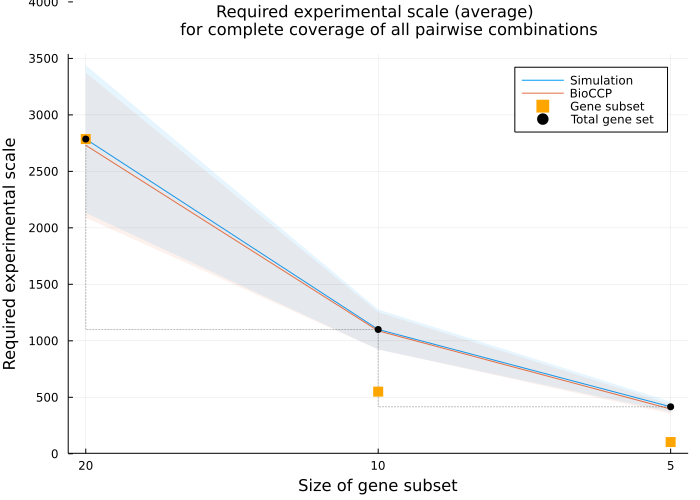

In [104]:
plot([20, 10, 5], E_split_sim, label="Simulation", 
    title="Required experimental scale (average) 
    for complete coverage of all pairwise combinations
    ", xlabel="Size of gene subset", ylabel="Required experimental scale",
    ribbon = sd_split_sim, fillalpha=.1,
    xticks = ([20, 10, 5], string.([20, 10, 5])),
    yticks = (0:500:4000, string.(0:500:4000)),
size = ((700,500)),
titlefont=font(11),
guidefontsize =11, guidefontfamily=101)


plot!(collect([20, 10, 5]), E_split_bioccp,  label="BioCCP",
    ribbon = sd_split_bioccp, 
    fillalpha=.1,
    xflip=true
)


plot!([20, 10, 5], E_split_sim,  label="", xaxis=:log10, linestyle = :dot, linealpha = 0.5,
    seriestype = :steppre, linecolor = :black)

scatter!([20, 10,5], [E_20_sim, E_10_sim, E_5_sim],markersize = 5, markercolor = :orange, 
    label="Gene subset", markershape = :square,     markerstrokecolor = :orange,
)
scatter!([20,10,5], [E_20_sim, 2*E_10_sim, 4*E_5_sim],markersize = 4, markercolor = :black, label="Total gene set")

In [105]:
n_gRNA_perconstruct = 2

2

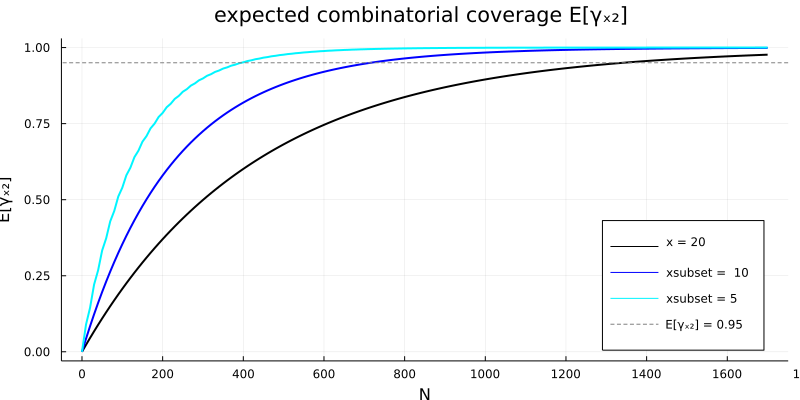

In [110]:
sample_sizes = 0:10:1700
expected_fraction_20= []
expected_fraction_10_10 = []
expected_fraction_5_5_5_5 = []

for sample_size in sample_sizes
    n_targets = 20
    n_gRNA_total = n_targets * n_gRNA_pergene
    ρ = 2; l = 50; u = ρ*l; m= (l+u)/2; sd= (u-l)/2; Random.seed!(1); p_gRNA_library = gRNA_frequency_distribution(m, sd, l, u, n_gRNA_total; normalize=true)
    p_active = 0.9; high_activity = 0.9; low_activity = 0.1; sd_activity = 0.01; Random.seed!(1); p_gRNA_act = gRNA_activity_distribution(p_active, high_activity, low_activity, sd_activity, n_gRNA_total; visualize=false) 

    push!(expected_fraction_20, BioCCP_γₓ₂(n_targets, sample_size,
                                         n_gRNA_pergene, 
                                         n_gRNA_perconstruct, 
                                         n_gRNA_total, 
                                         p_gRNA_library, 
                                         p_gRNA_act, ϵ_knockout_global))
    
    n_targets = 10
    n_gRNA_total = n_targets * n_gRNA_pergene
    ρ = 2; l = 50; u = ρ*l; m= (l+u)/2; sd= (u-l)/2; Random.seed!(1); p_gRNA_library = gRNA_frequency_distribution(m, sd, l, u, n_gRNA_total; normalize=true)
    p_active = 0.9; high_activity = 0.9; low_activity = 0.1; sd_activity = 0.01; Random.seed!(1); p_gRNA_act = gRNA_activity_distribution(p_active, high_activity, low_activity, sd_activity, n_gRNA_total; visualize=false) 

    push!(expected_fraction_10_10, BioCCP_γₓ₂(n_targets, Int(ceil(sample_size/2)),
                                         n_gRNA_pergene, 
                                         n_gRNA_perconstruct, 
                                         n_gRNA_total, 
                                         p_gRNA_library, 
                                         p_gRNA_act, ϵ_knockout_global))
    
    n_targets = 5
    n_gRNA_total = n_targets * n_gRNA_pergene
    ρ = 2; l = 50; u = ρ*l; m= (l+u)/2; sd= (u-l)/2; Random.seed!(1); p_gRNA_library = gRNA_frequency_distribution(m, sd, l, u, n_gRNA_total; normalize=true)
    p_active = 0.9; high_activity = 0.9; low_activity = 0.1; sd_activity = 0.01; Random.seed!(1); p_gRNA_act = gRNA_activity_distribution(p_active, high_activity, low_activity, sd_activity, n_gRNA_total; visualize=false) 

    push!(expected_fraction_5_5_5_5, BioCCP_γₓ₂(n_targets, Int(ceil(sample_size/4)),
                                         n_gRNA_pergene, 
                                         n_gRNA_perconstruct, 
                                         n_gRNA_total, 
                                         p_gRNA_library, 
                                         p_gRNA_act, ϵ_knockout_global))

  
end
 
plot(sample_sizes, expected_fraction_20, label="x = 20
    ", color=:black, linewidth=2)

plot!(sample_sizes, expected_fraction_10_10,
label="xsubset =  10", title="expected combinatorial coverage E[γₓ₂] 
    ",
xlabel="N", ylabel="E[γₓ₂]", 
        xticks = (0:200:50000, string.(0:200:50000)),
 size=(800,400), color=:blue, linewidth=2)

plot!(sample_sizes, expected_fraction_5_5_5_5, label="xsubset = 5", color=:turquoise1, linewidth=2)


hline!([0.95], linestyle=:dash, color=:grey, label="E[γₓ₂] = 0.95", legend=:bottomright)

Overshoot RES3

In [112]:
n_gRNA_pergene = 6
n_gRNA_perconstruct = 3
ϵ_knockout_global = 0.8

In [114]:
### N = 10
n_targets = 10
n_gRNA_total = n_targets * n_gRNA_pergene
Random.seed!(80)
ρ = 2
l = 50
u = ρ*l 
m= (l+u)/2
sd= (u-l)/2
Random.seed!(1)
p_gRNA_library = gRNA_frequency_distribution(m, sd, l, u, n_gRNA_total; normalize=true)
p_active = 0.9; high_activity = 0.9; low_activity = 0.1; sd_activity = 0.01
Random.seed!(1)
p_gRNA_act = gRNA_activity_distribution(p_active, high_activity, low_activity, sd_activity, n_gRNA_total; visualize=false) ;

E_10_bioccp, sd_10_bioccp = BioCCP_Nₓ₃(n_targets, 
                              n_gRNA_pergene, 
                              n_gRNA_perconstruct, 
                              n_gRNA_total, 
                              p_gRNA_library, 
                              p_gRNA_act, ϵ_knockout_global)

### N = 20
n_targets = 20
n_gRNA_total = n_targets * n_gRNA_pergene
ρ = 2
l = 50
u = ρ*l 
m= (l+u)/2
sd= (u-l)/2
Random.seed!(1)
p_gRNA_library = gRNA_frequency_distribution(m, sd, l, u, n_gRNA_total; normalize=true)
p_active = 0.9; high_activity = 0.9; low_activity = 0.1; sd_activity = 0.01
Random.seed!(1)
p_gRNA_act = gRNA_activity_distribution(p_active, high_activity, low_activity, sd_activity, n_gRNA_total; visualize=false) ;

E_20_bioccp, sd_20_bioccp = BioCCP_Nₓ₃(n_targets, 
                              n_gRNA_pergene, 
                              n_gRNA_perconstruct, 
                              n_gRNA_total, 
                              p_gRNA_library, 
                              p_gRNA_act, ϵ_knockout_global)


### N = 40
n_targets = 40
n_gRNA_total = n_targets * n_gRNA_pergene
ρ = 2
l = 50
u = ρ*l 
m= (l+u)/2
sd= (u-l)/2
Random.seed!(1)
p_gRNA_library = gRNA_frequency_distribution(m, sd, l, u, n_gRNA_total; normalize=true)
p_active = 0.9; high_activity = 0.9; low_activity = 0.1; sd_activity = 0.01
Random.seed!(1)
p_gRNA_act = gRNA_activity_distribution(p_active, high_activity, low_activity, sd_activity, n_gRNA_total; visualize=false) ;


E_40_bioccp, sd_40_bioccp = BioCCP_Nₓ₃(n_targets, 
                              n_gRNA_pergene, 
                              n_gRNA_perconstruct, 
                              n_gRNA_total, 
                              p_gRNA_library, 
                              p_gRNA_act, ϵ_knockout_global)


(454445, 74744)

In [115]:
E_split_bioccp = [E_40_bioccp, 2*E_20_bioccp, 4*E_10_bioccp]
sd_split_bioccp = [sd_40_bioccp, sd_20_bioccp, sd_10_bioccp]

3-element Vector{Int64}:
 74744
  6989
   883

In [116]:
E_split_bioccp

3-element Vector{Int64}:
 454445
  73542
  13604

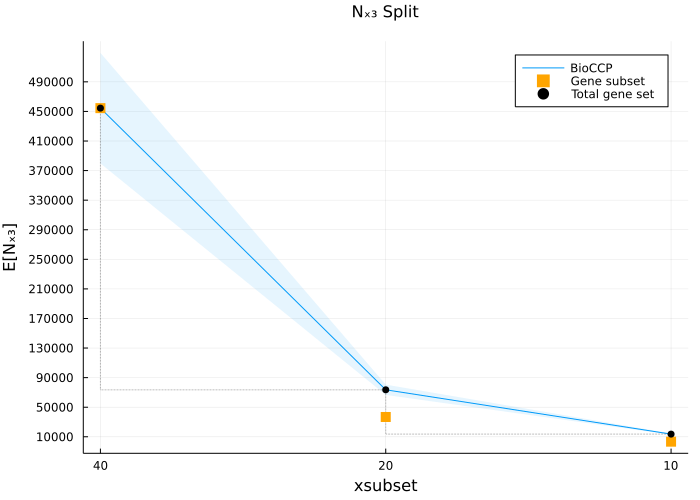

In [125]:
plot([40, 20, 10], E_split_bioccp, label="BioCCP", 
    title="Nₓ₃ Split
    ", xlabel="xsubset", ylabel="E[Nₓ₃]",
    ribbon = sd_split_bioccp, fillalpha=.1,
    xticks = ([40, 20, 10], string.([40, 20, 10])),
    yticks = (10000:40000:500000, string.(10000:40000:500000)),
size = ((700,500)),
titlefont=font(11),
guidefontsize =11, guidefontfamily=101, xflip=true)

plot!([40, 20, 10], E_split_bioccp,  label="", xaxis=:log10, linestyle = :dot, linealpha = 0.5,
    seriestype = :steppre, linecolor = :black)

scatter!([40, 20, 10], [E_40_bioccp, E_20_bioccp, E_10_bioccp],markersize = 5, markercolor = :orange, 
    label="Gene subset", markershape = :square,     markerstrokecolor = :orange,
)
scatter!([40, 20, 10], [E_40_bioccp, 2*E_20_bioccp, 4*E_10_bioccp],markersize = 4, markercolor = :black, label="Total gene set")

## percentage inactive gRNAs

In [130]:
n_targets = 20
n_gRNA_pergene = 6
n_gRNA_total= n_targets * n_gRNA_pergene
n_gRNA_perconstruct = 2
ϵ_knockout_global = 0.8
Random.seed!(80)
m= 300; sd= 175; l = 200; u = 400
p_gRNA_lib = gRNA_library_distribution(m, sd, l, u, n_gRNA_total; normalize=true);

In [131]:
## 10
Random.seed!(80)
p_active = 0.9; high_activity = 0.9; low_activity = 0.1; sd = 0.01
p_gRNA_act = gRNA_activity_distribution(p_active, high_activity, low_activity, sd, n_gRNA_total; visualize=false) ;


E_p_inact10_bioccp, sd_p_inact10_bioccp = BioCCP_minsamplesize_pairwise(n_targets, 
                              n_gRNA_pergene, 
                              n_gRNA_perconstruct, 
                              n_gRNA_total, 
                              p_gRNA_lib, 
                              p_gRNA_act, ϵ_knockout_global)

E_p_inact10_sim, sd_p_inact10_sim = simulate_minsamplesize_pairwise(n_targets, 
                                n_gRNA_pergene, 
                                n_gRNA_perconstruct, 
                                n_gRNA_total, 
                                p_gRNA_lib, 
                                p_gRNA_act, ϵ_knockout_global; iter=500)

## 20
Random.seed!(80)
p_active = 0.8; high_activity = 0.9; low_activity = 0.1; sd = 0.01
p_gRNA_act = gRNA_activity_distribution(p_active, high_activity, low_activity, sd, n_gRNA_total; visualize=false) ;

E_p_inact20_bioccp, sd_p_inact20_bioccp = BioCCP_minsamplesize_pairwise(n_targets, 
                              n_gRNA_pergene, 
                              n_gRNA_perconstruct, 
                              n_gRNA_total, 
                              p_gRNA_lib, 
                              p_gRNA_act, ϵ_knockout_global)

E_p_inact20_sim, sd_p_inact20_sim = simulate_minsamplesize_pairwise(n_targets, 
                                n_gRNA_pergene, 
                                n_gRNA_perconstruct, 
                                n_gRNA_total, 
                                p_gRNA_lib, 
                                p_gRNA_act, ϵ_knockout_global; iter=500)

## 30
Random.seed!(80)
p_active = 0.7; high_activity = 0.9; low_activity = 0.1; sd = 0.01
p_gRNA_act = gRNA_activity_distribution(p_active, high_activity, low_activity, sd, n_gRNA_total; visualize=false) ;

E_p_inact30_bioccp, sd_p_inact30_bioccp = BioCCP_minsamplesize_pairwise(n_targets, 
                              n_gRNA_pergene, 
                              n_gRNA_perconstruct, 
                              n_gRNA_total, 
                              p_gRNA_lib, 
                              p_gRNA_act, ϵ_knockout_global)

E_p_inact30_sim, sd_p_inact30_sim = simulate_minsamplesize_pairwise(n_targets, 
                                n_gRNA_pergene, 
                                n_gRNA_perconstruct, 
                                n_gRNA_total, 
                                p_gRNA_lib, 
                                p_gRNA_act, ϵ_knockout_global; iter=500)

Iteration: 100 ... Calculating minimum number of plants ... 

Iteration: 200 ... Calculating minimum number of plants ... 

Iteration: 300 ... Calculating minimum number of plants ... 

Iteration: 400 ... Calculating minimum number of plants ... 

Iteration: 500 ... Calculating minimum number of plants ... 

Iteration: 100 ... Calculating minimum number of plants ... 

Iteration: 200 ... Calculating minimum number of plants ... 

Iteration: 300 ... Calculating minimum number of plants ... 

Iteration: 400 ... Calculating minimum number of plants ... 

Iteration: 500 ... Calculating minimum number of plants ... 

Iteration: 100 ... Calculating minimum number of plants ... 

Iteration: 200 ... Calculating minimum number of plants ... 

Iteration: 300 ... Calculating minimum number of plants ... 

Iteration: 400 ... Calculating minimum number of plants ... 

Iteration: 500 ... Calculating minimum number of plants ... 



(8495.454, 2763.8000726476466)

In [132]:
E_p_inact_sim = [E_p_inact10_sim, E_p_inact20_sim, E_p_inact30_sim]
E_p_inact_bioccp = [E_p_inact10_bioccp, E_p_inact20_bioccp, E_p_inact30_bioccp]
sd_p_inact_sim = [sd_p_inact10_sim, sd_p_inact20_sim, sd_p_inact30_sim]
sd_p_inact_bioccp = [sd_p_inact10_bioccp, sd_p_inact20_bioccp, sd_p_inact30_bioccp]

3-element Array{Int64,1}:
  929
 1282
 3070

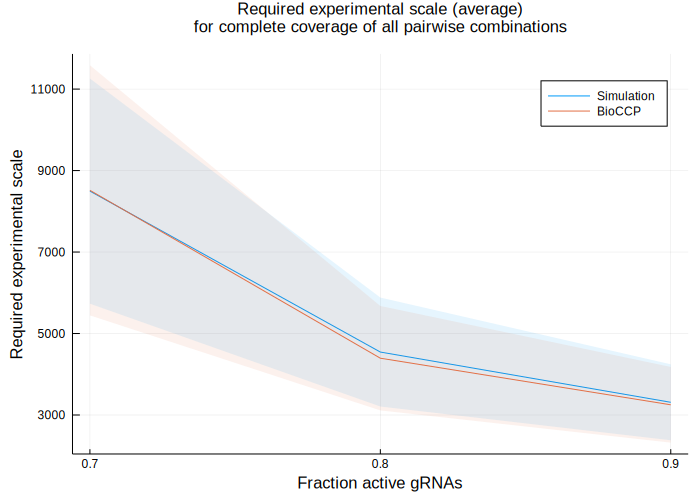

In [149]:
plot([0.7, 0.8, 0.9], [E_p_inact30_sim, E_p_inact20_sim, E_p_inact10_sim], label="Simulation", 
    title="Required experimental scale (average) 
    for complete coverage of all pairwise combinations
    ", xlabel="Fraction active gRNAs", ylabel="Required experimental scale",
    ribbon = [sd_p_inact30_sim, sd_p_inact20_sim, sd_p_inact10_sim], fillalpha=.1,
    xticks = ([0.7, 0.8, 0.9], string.([0.7, 0.8, 0.9])),
    yticks = (3000:2000:11000, string.(3000:2000:11000)),
size = ((700,500)),
titlefont=font(11),
guidefontsize =11, guidefontfamily=101)

plot!([0.7, 0.8, 0.9], [E_p_inact30_bioccp, E_p_inact20_bioccp, E_p_inact10_bioccp],  label="BioCCP",
    ribbon = [sd_p_inact30_bioccp, sd_p_inact20_bioccp, sd_p_inact10_bioccp], 
    fillalpha=.1,
)


## knockout efficiency

In [134]:
n_targets = 20
n_gRNA_pergene = 6
n_gRNA_total= n_targets * n_gRNA_pergene
n_gRNA_perconstruct = 2

ρ = 2
l = 50
u = ρ*l 
m= (l+u)/2
sd= (u-l)/2
Random.seed!(1)
p_gRNA_lib = gRNA_frequency_distribution(m, sd, l, u, n_gRNA_total; normalize=true)
p_active = 0.9; high_activity = 0.9; low_activity = 0.1; sd_activity = 0.01
Random.seed!(1)
p_gRNA_act = gRNA_activity_distribution(p_active, high_activity, low_activity, sd_activity, n_gRNA_total; visualize=false) ;

In [135]:
## 70
ϵ_knockout_global = 0.7

E_p_KO70_bioccp, sd_p_KO70_bioccp = BioCCP_Nₓ₂(n_targets, 
                              n_gRNA_pergene, 
                              n_gRNA_perconstruct, 
                              n_gRNA_total, 
                              p_gRNA_lib, 
                              p_gRNA_act, ϵ_knockout_global)

E_p_KO70_sim, sd_p_KO70_sim = simulate_Nₓ₂(n_targets, 
                                n_gRNA_pergene, 
                                n_gRNA_perconstruct, 
                                n_gRNA_total, 
                                p_gRNA_lib, 
                                p_gRNA_act, ϵ_knockout_global; iter=500)

## 80
ϵ_knockout_global = 0.8

E_p_KO80_bioccp, sd_p_KO80_bioccp = BioCCP_Nₓ₂(n_targets, 
                              n_gRNA_pergene, 
                              n_gRNA_perconstruct, 
                              n_gRNA_total, 
                              p_gRNA_lib, 
                              p_gRNA_act, ϵ_knockout_global)

E_p_KO80_sim, sd_p_KO80_sim = simulate_Nₓ₂(n_targets, 
                                n_gRNA_pergene, 
                                n_gRNA_perconstruct, 
                                n_gRNA_total, 
                                p_gRNA_lib, 
                                p_gRNA_act, ϵ_knockout_global; iter=500)

## 90
ϵ_knockout_global = 0.9

E_p_KO90_bioccp, sd_p_KO90_bioccp = BioCCP_Nₓ₂(n_targets, 
                              n_gRNA_pergene, 
                              n_gRNA_perconstruct, 
                              n_gRNA_total, 
                              p_gRNA_lib, 
                              p_gRNA_act, ϵ_knockout_global)

E_p_KO90_sim, sd_p_KO90_sim = simulate_Nₓ₂(n_targets, 
                                n_gRNA_pergene, 
                                n_gRNA_perconstruct, 
                                n_gRNA_total, 
                                p_gRNA_lib, 
                                p_gRNA_act, ϵ_knockout_global; iter=500)
## 100
ϵ_knockout_global = 1

E_p_KO100_bioccp, sd_p_KO100_bioccp = BioCCP_Nₓ₂(n_targets, 
                              n_gRNA_pergene, 
                              n_gRNA_perconstruct, 
                              n_gRNA_total, 
                              p_gRNA_lib, 
                              p_gRNA_act, ϵ_knockout_global)

E_p_KO100_sim, sd_p_KO100_sim = simulate_Nₓ₂(n_targets, 
                                n_gRNA_pergene, 
                                n_gRNA_perconstruct, 
                                n_gRNA_total, 
                                p_gRNA_lib, 
                                p_gRNA_act, ϵ_knockout_global; iter=500)

Iteration: 100 ... Calculating minimum number of plants ... 

Iteration: 200 ... Calculating minimum number of plants ... 

Iteration: 300 ... Calculating minimum number of plants ... 

Iteration: 400 ... Calculating minimum number of plants ... 

Iteration: 500 ... Calculating minimum number of plants ... 

Iteration: 100 ... Calculating minimum number of plants ... 

Iteration: 200 ... Calculating minimum number of plants ... 

Iteration: 300 ... Calculating minimum number of plants ... 

Iteration: 400 ... Calculating minimum number of plants ... 

Iteration: 500 ... Calculating minimum number of plants ... 

Iteration: 100 ... Calculating minimum number of plants ... 

Iteration: 200 ... Calculating minimum number of plants ... 

Iteration: 300 ... Calculating minimum number of plants ... 

Iteration: 400 ... Calculating minimum number of plants ... 

Iteration: 500 ... Calculating minimum number of plants ... 

Iteration: 100 ... Calculating minimum number of plants ... 

Iteratio

(1762.99, 417.93251257845475)

In [136]:
E_p_KO_sim = [E_p_KO70_sim, E_p_KO80_sim, E_p_KO90_sim,E_p_KO100_sim]
E_p_KO_bioccp = [E_p_KO70_bioccp, E_p_KO80_bioccp, E_p_KO90_bioccp, E_p_KO100_bioccp]
sd_p_KO_sim = [sd_p_KO70_sim, sd_p_KO80_sim, sd_p_KO90_sim,sd_p_KO100_sim]
sd_p_KO_bioccp = [sd_p_KO70_bioccp, sd_p_KO80_bioccp, sd_p_KO90_bioccp, sd_p_KO100_bioccp];

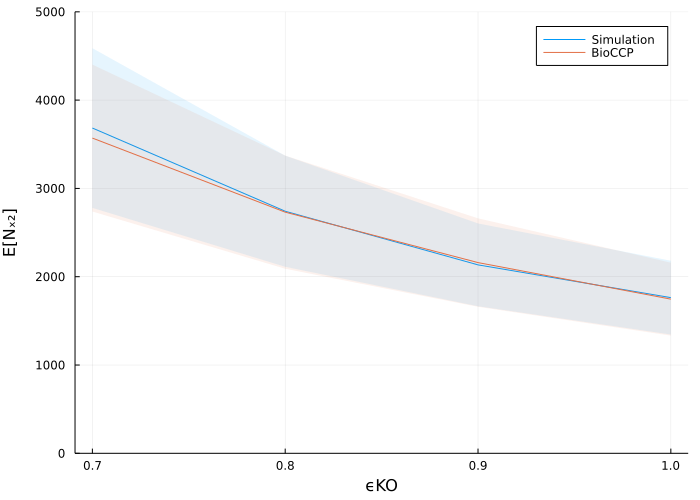

In [141]:
plot([0.7, 0.8, 0.9, 1], E_p_KO_sim, label="Simulation", 
    title="", xlabel="ϵKO", ylabel="E[Nₓ₂]",
    ribbon = sd_p_KO_sim, fillalpha=.1,
    xticks = ([0.7, 0.8, 0.9, 1], string.([0.7, 0.8, 0.9, 1])),
    yticks = (0:1000:11000, string.(0:1000:11000)),
    ylim=(0,5000),
size = ((700,500)),
titlefont=font(11),
guidefontsize =11, guidefontfamily=101)

plot!([0.7, 0.8, 0.9, 1], E_p_KO_bioccp,  label="BioCCP",
    ribbon = sd_p_KO_bioccp, 
    fillalpha=.1,
)


##### overshooting

In [143]:
n_targets = 20
n_gRNA_pergene = 6
n_gRNA_total = n_targets * n_gRNA_pergene
Random.seed!(1)
p_high_activity = 0.9
μ_high_activity = 0.9
μ_low_activity = 0.1
σ_activity = 0.01
ϵ_knockout_global = 0.8
ρ  = 2
l = 50
u = 50*ρ 
m= (l+u)/2
sd = (u-l)/2
Random.seed!(1)
p_gRNA_lib = gRNA_frequency_distribution(m, sd, l, u, gRNA_total; normalize = true, visualize=false);
Random.seed!(1)
p_gRNA_act = gRNA_activity_distribution(p_high_activity, μ_high_activity, μ_low_activity, σ_activity, n_gRNA_total; visualize=false); 


In [144]:
## 2
n_gRNA_perconstruct = 2

E_KO2_bioccp, sd_KO2_bioccp = BioCCP_Nₓ₂(n_targets, 
                              n_gRNA_pergene, 
                              n_gRNA_perconstruct, 
                              n_gRNA_total, 
                              p_gRNA_lib, 
                              p_gRNA_act, ϵ_knockout_global)

E_KO2_sim, sd_KO2_sim = simulate_Nₓ₂(n_targets, 
                                n_gRNA_pergene, 
                                n_gRNA_perconstruct, 
                                n_gRNA_total, 
                                p_gRNA_lib, 
                                p_gRNA_act, ϵ_knockout_global; iter=500)

## 3
n_gRNA_perconstruct = 3

E_KO3_bioccp, sd_KO3_bioccp = BioCCP_Nₓ₂(n_targets, 
                              n_gRNA_pergene, 
                              n_gRNA_perconstruct, 
                              n_gRNA_total, 
                              p_gRNA_lib, 
                              p_gRNA_act, ϵ_knockout_global)

E_KO3_sim, sd_KO3_sim = simulate_Nₓ₂(n_targets, 
                                n_gRNA_pergene, 
                                n_gRNA_perconstruct, 
                                n_gRNA_total, 
                                p_gRNA_lib, 
                                p_gRNA_act, ϵ_knockout_global; iter=500)

## 4
n_gRNA_perconstruct = 4

E_KO4_bioccp, sd_KO4_bioccp = BioCCP_Nₓ₂(n_targets, 
                              n_gRNA_pergene, 
                              n_gRNA_perconstruct, 
                              n_gRNA_total, 
                              p_gRNA_lib, 
                              p_gRNA_act, ϵ_knockout_global)

E_KO4_sim, sd_KO4_sim = simulate_Nₓ₂(n_targets, 
                                n_gRNA_pergene, 
                                n_gRNA_perconstruct, 
                                n_gRNA_total, 
                                p_gRNA_lib, 
                                p_gRNA_act, ϵ_knockout_global; iter=500)
## 5
n_gRNA_perconstruct = 5

E_KO5_bioccp, sd_KO5_bioccp = BioCCP_Nₓ₂(n_targets, 
                              n_gRNA_pergene, 
                              n_gRNA_perconstruct, 
                              n_gRNA_total, 
                              p_gRNA_lib, 
                              p_gRNA_act, ϵ_knockout_global)

E_KO5_sim, sd_KO5_sim = simulate_Nₓ₂(n_targets, 
                                n_gRNA_pergene, 
                                n_gRNA_perconstruct, 
                                n_gRNA_total, 
                                p_gRNA_lib, 
                                p_gRNA_act, ϵ_knockout_global; iter=500)


## 6
n_gRNA_perconstruct = 6

E_KO6_bioccp, sd_KO6_bioccp = BioCCP_Nₓ₂(n_targets, 
                              n_gRNA_pergene, 
                              n_gRNA_perconstruct, 
                              n_gRNA_total, 
                              p_gRNA_lib, 
                              p_gRNA_act, ϵ_knockout_global)

E_KO6_sim, sd_KO6_sim = simulate_Nₓ₂(n_targets, 
                                n_gRNA_pergene, 
                                n_gRNA_perconstruct, 
                                n_gRNA_total, 
                                p_gRNA_lib, 
                                p_gRNA_act, ϵ_knockout_global; iter=500);

Iteration: 100 ... Calculating minimum number of plants ... 

Iteration: 200 ... Calculating minimum number of plants ... 

Iteration: 300 ... Calculating minimum number of plants ... 

Iteration: 400 ... Calculating minimum number of plants ... 

Iteration: 500 ... Calculating minimum number of plants ... 

Iteration: 100 ... Calculating minimum number of plants ... 

Iteration: 200 ... Calculating minimum number of plants ... 

Iteration: 300 ... Calculating minimum number of plants ... 

Iteration: 400 ... Calculating minimum number of plants ... 

Iteration: 500 ... Calculating minimum number of plants ... 

Iteration: 100 ... Calculating minimum number of plants ... 

Iteration: 200 ... Calculating minimum number of plants ... 

Iteration: 300 ... Calculating minimum number of plants ... 

Iteration: 400 ... Calculating minimum number of plants ... 

Iteration: 500 ... Calculating minimum number of plants ... 

Iteration: 100 ... Calculating minimum number of plants ... 

Iteratio

In [145]:
E_KO_sim = [E_KO2_sim, E_KO3_sim, E_KO4_sim, E_KO5_sim,E_KO6_sim]
E_KO_bioccp = [E_KO2_bioccp, E_KO3_bioccp, E_KO4_bioccp, E_KO5_bioccp, E_KO6_bioccp]
sd_KO_sim = [sd_KO2_sim,sd_KO3_sim, sd_KO4_sim, sd_KO5_sim, sd_KO6_sim]
sd_KO_bioccp = [sd_KO2_bioccp, sd_KO3_bioccp, sd_KO4_bioccp, sd_KO5_bioccp, sd_KO6_bioccp]

5-element Vector{Int64}:
 641
 212
 106
  60
  41

In [146]:
E_KO_sim

5-element Vector{Float64}:
 2785.944
  935.074
  490.266
  304.484
  207.532

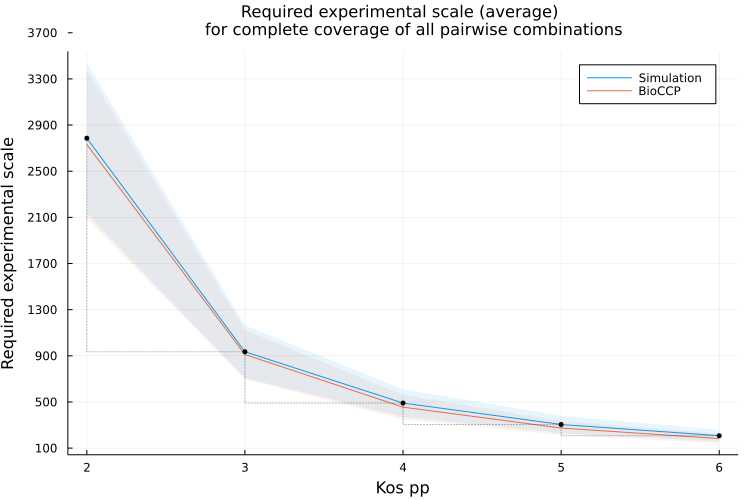

In [147]:
plot(2:6, E_KO_sim, label="Simulation", 
    title="Required experimental scale (average) 
    for complete coverage of all pairwise combinations
    ", xlabel="Kos pp", ylabel="Required experimental scale",
    ribbon = sd_KO_sim, fillalpha=.1,
    xticks = (2:6, string.(2:6)),
    yticks = (100:400:10000, string.(100:400:10000)),
size = ((750,500)),
titlefont=font(11),
guidefontsize =11, guidefontfamily=101)

plot!(2:6, E_KO_bioccp,  label="BioCCP",
    ribbon = sd_KO_bioccp, 
    fillalpha=.1,
)

plot!(2:6, E_KO_sim,  label="",linestyle = :dot, linealpha = 0.5,
    seriestype = :steppre, linecolor = :black)

scatter!(2:6, E_KO_sim,  label="",markersize = 3, markercolor = :black)

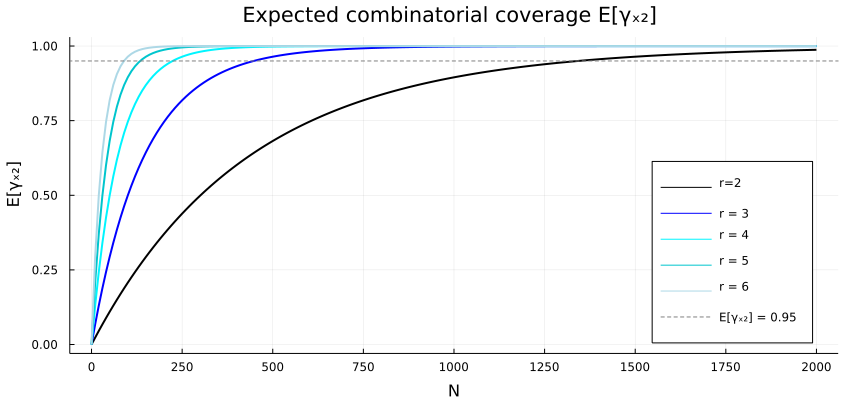

In [154]:
sample_sizes = 0:10:2000
expected_fraction_2 = []
expected_fraction_3 = []
expected_fraction_4 = []
expected_fraction_5 = []
expected_fraction_6 = []

for sample_size in sample_sizes
    n_gRNA_perconstruct = 2
    push!(expected_fraction_2, BioCCP_γₓ₂(n_targets, sample_size,
                                         n_gRNA_pergene, 
                                         n_gRNA_perconstruct, 
                                         n_gRNA_total, 
                                         p_gRNA_library, 
                                         p_gRNA_act, ϵ_knockout_global))
    
    n_gRNA_perconstruct = 3
    push!(expected_fraction_3, BioCCP_γₓ₂(n_targets, sample_size,
                                         n_gRNA_pergene, 
                                         n_gRNA_perconstruct, 
                                         n_gRNA_total, 
                                         p_gRNA_library, 
                                         p_gRNA_act, ϵ_knockout_global))
    
    n_gRNA_perconstruct = 4
    push!(expected_fraction_4, BioCCP_γₓ₂(n_targets, sample_size,
                                         n_gRNA_pergene, 
                                         n_gRNA_perconstruct, 
                                         n_gRNA_total, 
                                         p_gRNA_library, 
                                         p_gRNA_act, ϵ_knockout_global))
    n_gRNA_perconstruct = 5
    push!(expected_fraction_5, BioCCP_γₓ₂(n_targets, sample_size,
                                         n_gRNA_pergene, 
                                         n_gRNA_perconstruct, 
                                         n_gRNA_total, 
                                         p_gRNA_library, 
                                         p_gRNA_act, ϵ_knockout_global))
    
    n_gRNA_perconstruct = 6
    push!(expected_fraction_6, BioCCP_γₓ₂(n_targets, sample_size,
                                         n_gRNA_pergene, 
                                         n_gRNA_perconstruct, 
                                         n_gRNA_total, 
                                         p_gRNA_library, 
                                         p_gRNA_act, ϵ_knockout_global))
  
end
 
plot(sample_sizes, expected_fraction_2, label="r=2
    ", color=:black, linewidth=2)

plot!(sample_sizes, expected_fraction_3,
label="r = 3", title="Expected combinatorial coverage E[γₓ₂] 
    ",
xlabel="N
    ", ylabel="
    E[γₓ₂]", 
        xticks = (0:250:50000, string.(0:250:50000)),
 size=(850,400), color=:blue, linewidth=2)

plot!(sample_sizes, expected_fraction_4, label="r = 4
    ", color=:turquoise1, linewidth=2)

plot!(sample_sizes, expected_fraction_5, label="r = 5
    ", color=:turquoise3, linewidth=2)

plot!(sample_sizes, expected_fraction_6, label="r = 6
    ", color=:lightblue, linewidth=2)

hline!([0.95], linestyle=:dash, color=:grey, label="E[γₓ₂] = 0.95", legend=:bottomright)


#### Triples

In [155]:
## 3
n_gRNA_perconstruct = 3

E_KO3_bioccp, sd_KO3_bioccp = BioCCP_Nₓ₃(n_targets, 
                              n_gRNA_pergene, 
                              n_gRNA_perconstruct, 
                              n_gRNA_total, 
                              p_gRNA_lib, 
                              p_gRNA_act, ϵ_knockout_global)

E_KO3_sim, sd_KO3_sim = simulate_Nₓ₃(n_targets, 
                                n_gRNA_pergene, 
                                n_gRNA_perconstruct, 
                                n_gRNA_total, 
                                p_gRNA_lib, 
                                p_gRNA_act, ϵ_knockout_global; iter=500)

## 4
n_gRNA_perconstruct = 4

E_KO4_bioccp, sd_KO4_bioccp = BioCCP_Nₓ₃(n_targets, 
                              n_gRNA_pergene, 
                              n_gRNA_perconstruct, 
                              n_gRNA_total, 
                              p_gRNA_lib, 
                              p_gRNA_act, ϵ_knockout_global)

E_KO4_sim, sd_KO4_sim = simulate_Nₓ₃(n_targets, 
                                n_gRNA_pergene, 
                                n_gRNA_perconstruct, 
                                n_gRNA_total, 
                                p_gRNA_lib, 
                                p_gRNA_act, ϵ_knockout_global; iter=500)
## 5
n_gRNA_perconstruct = 5

E_KO5_bioccp, sd_KO5_bioccp = BioCCP_Nₓ₃(n_targets, 
                              n_gRNA_pergene, 
                              n_gRNA_perconstruct, 
                              n_gRNA_total, 
                              p_gRNA_lib, 
                              p_gRNA_act, ϵ_knockout_global)

E_KO5_sim, sd_KO5_sim = simulate_Nₓ₃(n_targets, 
                                n_gRNA_pergene, 
                                n_gRNA_perconstruct, 
                                n_gRNA_total, 
                                p_gRNA_lib, 
                                p_gRNA_act, ϵ_knockout_global; iter=500)


## 6
n_gRNA_perconstruct = 6

E_KO6_bioccp, sd_KO6_bioccp = BioCCP_Nₓ₃(n_targets, 
                              n_gRNA_pergene, 
                              n_gRNA_perconstruct, 
                              n_gRNA_total, 
                              p_gRNA_lib, 
                              p_gRNA_act, ϵ_knockout_global)

E_KO6_sim, sd_KO6_sim = simulate_Nₓ₃(n_targets, 
                                n_gRNA_pergene, 
                                n_gRNA_perconstruct, 
                                n_gRNA_total, 
                                p_gRNA_lib, 
                                p_gRNA_act, ϵ_knockout_global; iter=500)

Iteration: 100 ... Calculating minimum number of plants ... 

Iteration: 200 ... Calculating minimum number of plants ... 

Iteration: 300 ... Calculating minimum number of plants ... 

Iteration: 400 ... Calculating minimum number of plants ... 

Iteration: 500 ... Calculating minimum number of plants ... 

Iteration: 100 ... Calculating minimum number of plants ... 

Iteration: 200 ... Calculating minimum number of plants ... 

Iteration: 300 ... Calculating minimum number of plants ... 

Iteration: 400 ... Calculating minimum number of plants ... 

Iteration: 500 ... Calculating minimum number of plants ... 

Iteration: 100 ... Calculating minimum number of plants ... 

Iteration: 200 ... Calculating minimum number of plants ... 

Iteration: 300 ... Calculating minimum number of plants ... 

Iteration: 400 ... Calculating minimum number of plants ... 

Iteration: 500 ... Calculating minimum number of plants ... 

Iteration: 100 ... Calculating minimum number of plants ... 

Iteratio

(2185.48, 396.33066698804737)

In [159]:
E_KO_bioccp = [E_KO3_bioccp, E_KO4_bioccp, E_KO5_bioccp, E_KO6_bioccp];
sd_KO_bioccp = [sd_KO3_bioccp, sd_KO4_bioccp, sd_KO5_bioccp, sd_KO6_bioccp];

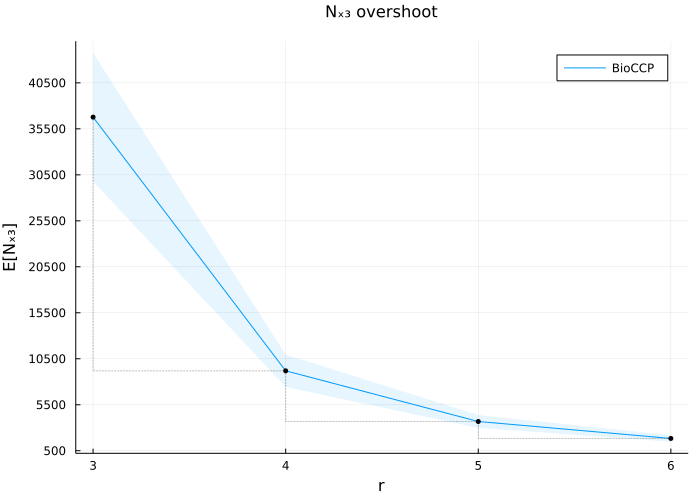

In [158]:
plot([3, 4, 5, 6], E_KO_bioccp, label="BioCCP", 
    title="Nₓ₃ overshoot
    ", xlabel="r", ylabel="E[Nₓ₃]",
    ribbon = sd_KO_bioccp, fillalpha=.1,
    xticks = ([3,4,5,6], string.([3,4,5,6])),
    yticks = (500:5000:45000, string.(500:5000:45000)),
size = ((700,500)),
titlefont=font(11),
guidefontsize =11, guidefontfamily=101)

plot!([3,4,5,6], E_KO_bioccp,  label="",linestyle = :dot, linealpha = 0.5,
    seriestype = :steppre, linecolor = :black)
scatter!([3,4,5,6], E_KO_bioccp,  label="",markersize = 3, markercolor = :black)